## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [2]:
!pip install segmentation-models-pytorch


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.4 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=42ccbf5bdc592b2ef798734ec9186c50271b8b20f50f639882fead06749b6ae1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f7fdc5735ffacf31be9f0251d56497aa30056d6b639405e8ceff341e5c5419cc
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

## ⏳ Load the Data (no outlier)

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from skimage.util import random_noise
from scipy.ndimage import rotate

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load dataset
data_train = np.load("/kaggle/input/clean-ds-mars/clean/train.npz")
data_test = np.load("/kaggle/input/clean-ds-mars/clean/test.npz")
X_train = data_train["x"]
y_train = data_train["y"]
X_test = data_test["x"]




Using device: cuda


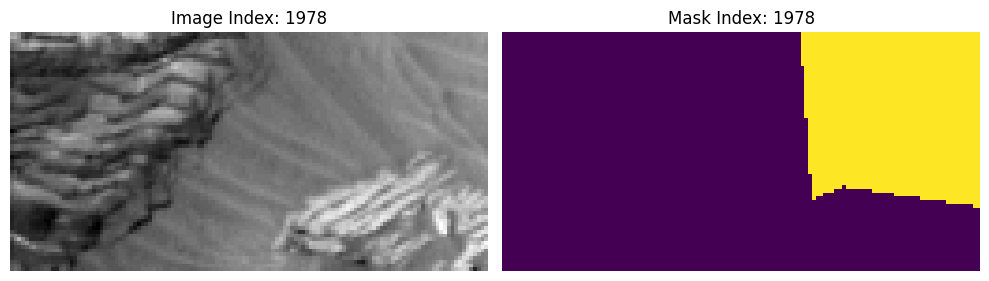

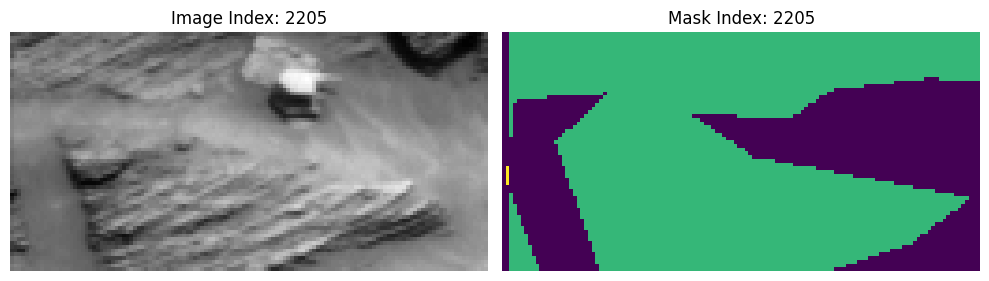

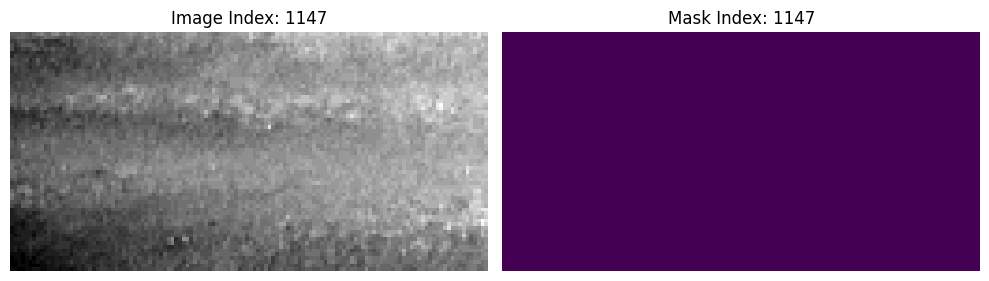

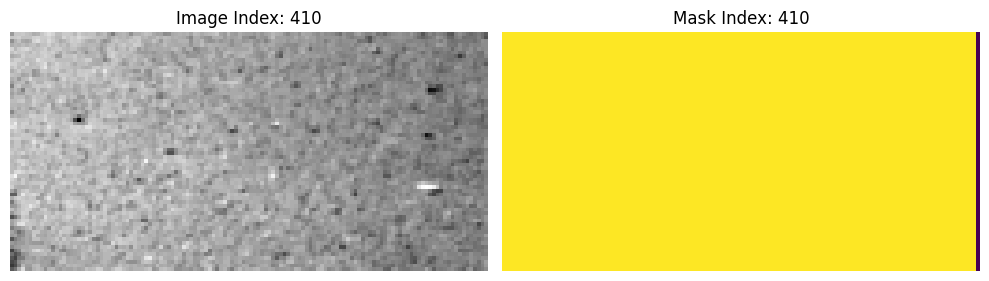

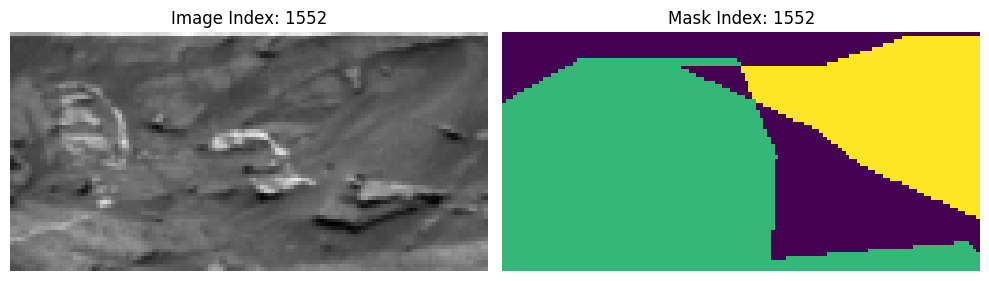

In [4]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## PYTORCH

In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from skimage.util import random_noise
from scipy.ndimage import rotate
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
from skimage.util import random_noise

# Define hyperparameters
hyperparams = {
    "model": {
        "architecture": "DeeplabV3+",
        "encoder_name": "resnet18", #resnet34
        "encoder_weights": None,
        "input_channels": 1,
        "num_classes": 5,
    },
    "training": {
        "batch_size": 32,
        "learning_rate": 1e-4,
        "num_epochs": 50,
    },
    "loss_function": {
        "type": "WeightedCrossEntropy",
    },
    "data": {
        "augmentation": {
            "rotation_angle": 20,
            "noise_amount": 0.03,
        },
    },
}



In [7]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
data_train = np.load("/kaggle/input/clean-ds-mars/clean/train.npz")
data_test = np.load("/kaggle/input/clean-ds-mars/clean/test.npz")
X_train = data_train["x"]
y_train = data_train["y"]
X_test = data_test["x"]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

"""X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=200, random_state=42
)"""

# Add channel dimension and normalize
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0



Using device: cuda


In [8]:
# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, images, masks=None, augmentations=None):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx] if self.masks is not None else None

        if self.augmentations:
            image, mask = self.augmentations(image, mask)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)
        mask = torch.tensor(mask, dtype=torch.long) if mask is not None else None
        return (image, mask) if mask is not None else image



In [9]:
from skimage.util import random_noise
from scipy.ndimage import rotate
import numpy as np

# Define individual augmentation functions
def rotate_image_and_mask(image, mask, angle):
    image = rotate(image, angle, reshape=False, mode="constant", order=1)
    mask = rotate(mask, angle, reshape=False, mode="constant", order=0)
    return image, mask

def add_noise_to_image(image, mask, noise_amount):
    image = random_noise(image, mode="s&p", amount=noise_amount)
    return np.clip(image, 0, 1), mask

def invert_image_and_mask(image, mask):
    image = 1.0 - image
    return image, mask

def flip_horizontal(image, mask):
    image = np.fliplr(image)
    mask = np.fliplr(mask)
    return image, mask

def flip_vertical(image, mask):
    image = np.flipud(image)
    mask = np.flipud(mask)
    return image, mask

# Apply augmentations and update X_train and y_train
def apply_augmentations_and_update(X_train, y_train):
    augmented_images = []
    augmented_masks = []

    augmentations = {
        "rotation": lambda img, msk: rotate_image_and_mask(img, msk, angle=np.random.uniform(-20, 20)),
        "noise": lambda img, msk: add_noise_to_image(img, msk, noise_amount=0.03),
        "invert": invert_image_and_mask,
        "horizontal_flip": flip_horizontal,
        "vertical_flip": flip_vertical,
    }

    # Apply each augmentation and collect augmented data
    for aug_name, aug_function in augmentations.items():
        print(f"Applying {aug_name} augmentation...")
        for image, mask in zip(X_train, y_train):
            aug_image, aug_mask = aug_function(image, mask)
            augmented_images.append(aug_image)
            augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Update X_train and y_train by concatenating augmented data
    X_train = np.concatenate([X_train, augmented_images], axis=0)
    y_train = np.concatenate([y_train, augmented_masks], axis=0)

    print(f"Updated X_train shape: {X_train.shape}")
    print(f"Updated y_train shape: {y_train.shape}")
    return X_train, y_train

# Apply augmentations and update datasets
X_train, y_train = apply_augmentations_and_update(X_train, y_train)

# DataLoaders
train_dataset = SegmentationDataset(X_train, y_train)
val_dataset = SegmentationDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=hyperparams["training"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Applying rotation augmentation...
Applying noise augmentation...
Applying invert augmentation...
Applying horizontal_flip augmentation...
Applying vertical_flip augmentation...
Updated X_train shape: (12024, 64, 128, 1)
Updated y_train shape: (12024, 64, 128)


In [10]:
import numpy as np

def compute_class_weights(masks, num_classes):
    masks_flat = masks.astype(np.int64).reshape(-1)  # Ensure integer type for bincount
    pixel_counts = np.bincount(masks_flat, minlength=num_classes)
    total_pixels = pixel_counts.sum()
    weights = total_pixels / (pixel_counts + 1e-6)  # Avoid division by zero
    return weights / weights.sum()

# Example usage
class_weights = compute_class_weights(y_train, hyperparams["model"]["num_classes"])
print("Computed class weights:", class_weights)


Computed class weights: [0.0048763  0.00375431 0.00528551 0.00701482 0.97906907]


In [11]:
import torch
import numpy as np

def calculate_mean_iou(y_true, y_pred, num_classes, ignore_class=0):
    """
    Calculate mean IoU and per-class IoU.

    Args:
        y_true (torch.Tensor): Ground truth masks of shape (N, H, W).
        y_pred (torch.Tensor): Predicted masks of shape (N, H, W).
        num_classes (int): Total number of classes.
        ignore_class (int): Class to ignore in IoU calculations.

    Returns:
        float: Mean IoU.
        dict: Per-class IoU.
    """
    ious = []
    class_ious = {}

    for c in range(num_classes):
        if c == ignore_class:
            continue

        y_true_c = (y_true == c).int()
        y_pred_c = (y_pred == c).int()

        intersection = (y_true_c & y_pred_c).sum().item()
        union = (y_true_c | y_pred_c).sum().item()

        iou = intersection / union if union > 0 else 0.0
        ious.append(iou)
        class_ious[c] = iou

    mean_iou = np.mean(ious) if ious else 0.0
    return mean_iou, class_ious


Epoch 1/50, Train Loss: 530.3206, Val Loss: 8.8248, Mean IoU: 0.3451, Val Accuracy: 0.5404
Class 0 IoU: 0.5110
Class 1 IoU: 0.3476
Class 2 IoU: 0.5098
Class 3 IoU: 0.0121


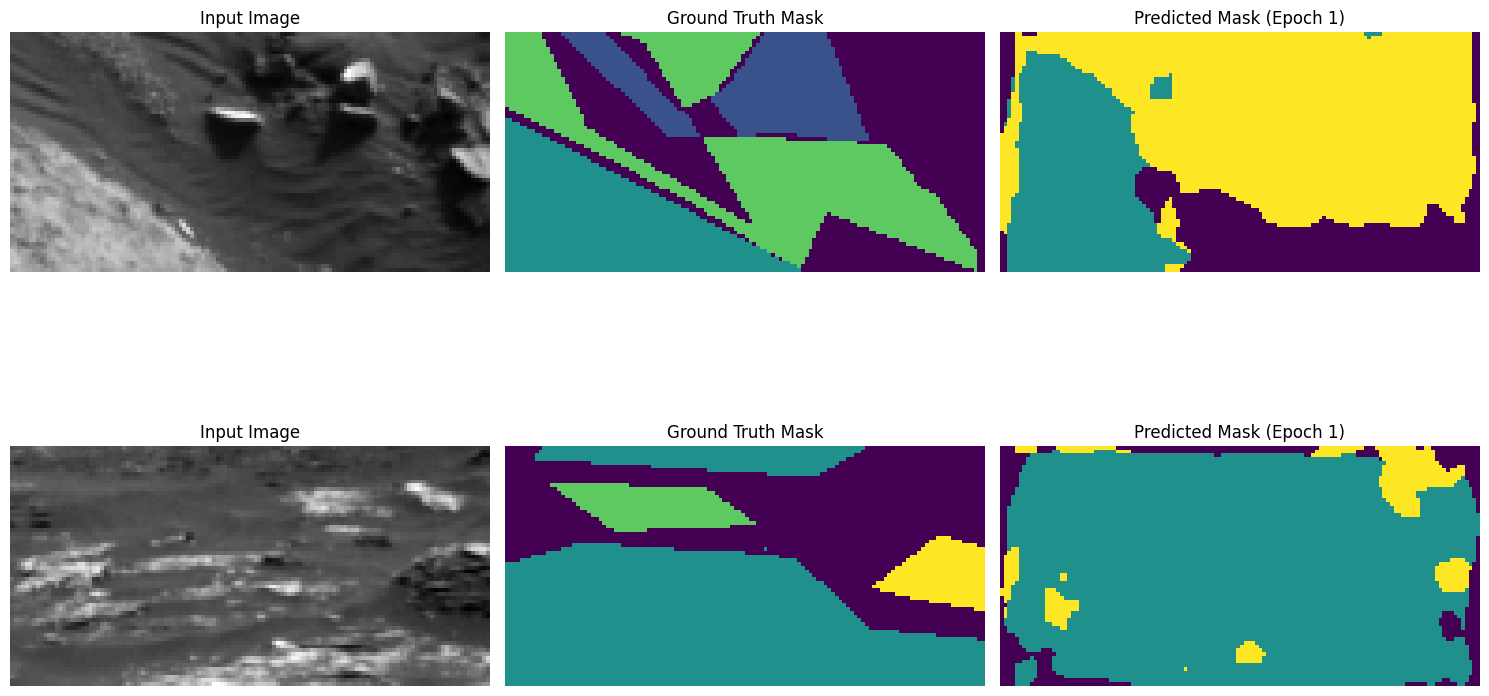

Model saved with new best Mean IoU: 0.3451
Model saved with new best Validation Accuracy: 0.5404
Model saved with new best Validation Loss: 8.8248
Epoch 2/50, Train Loss: 461.9405, Val Loss: 8.3147, Mean IoU: 0.3366, Val Accuracy: 0.5857
Class 0 IoU: 0.5213
Class 1 IoU: 0.2426
Class 2 IoU: 0.5541
Class 3 IoU: 0.0283


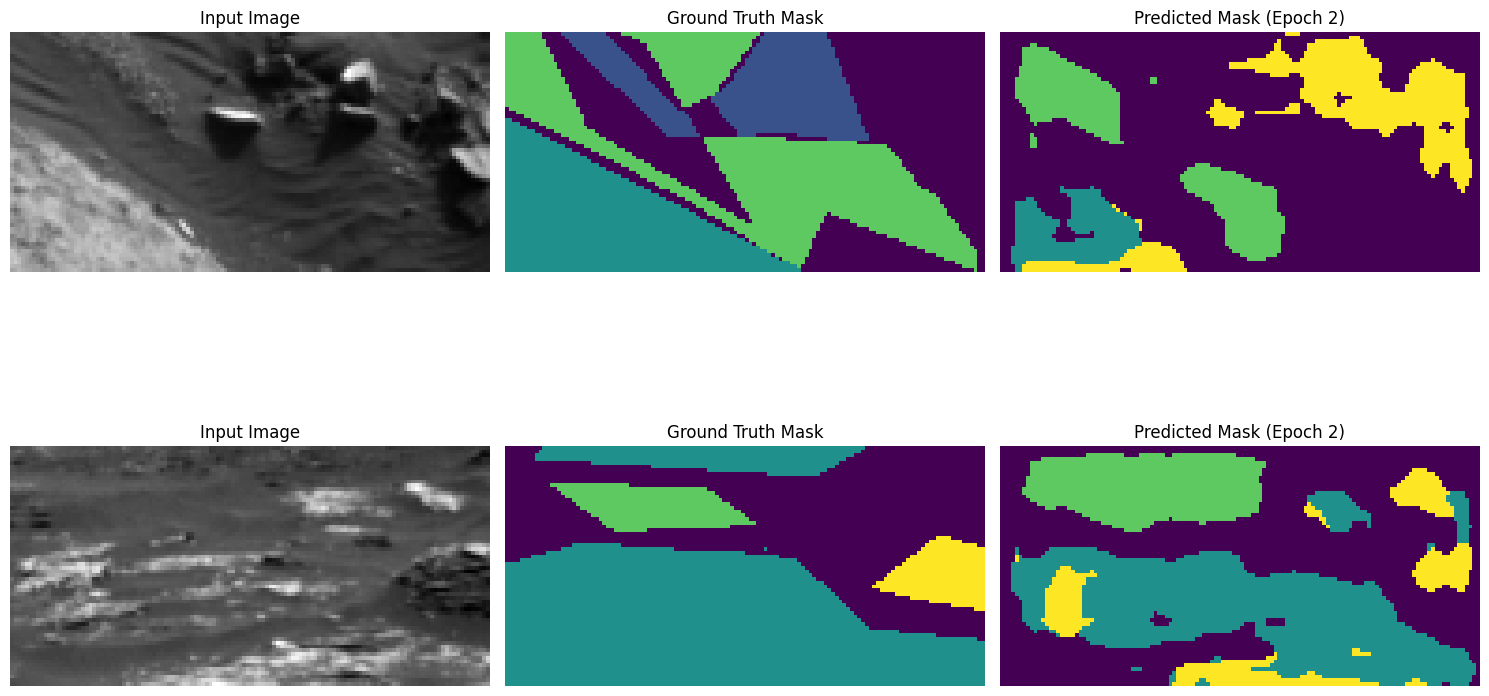

Model saved with new best Validation Accuracy: 0.5857
Model saved with new best Validation Loss: 8.3147
Epoch 3/50, Train Loss: 425.4445, Val Loss: 7.1777, Mean IoU: 0.3825, Val Accuracy: 0.6122
Class 0 IoU: 0.5270
Class 1 IoU: 0.4389
Class 2 IoU: 0.5399
Class 3 IoU: 0.0240


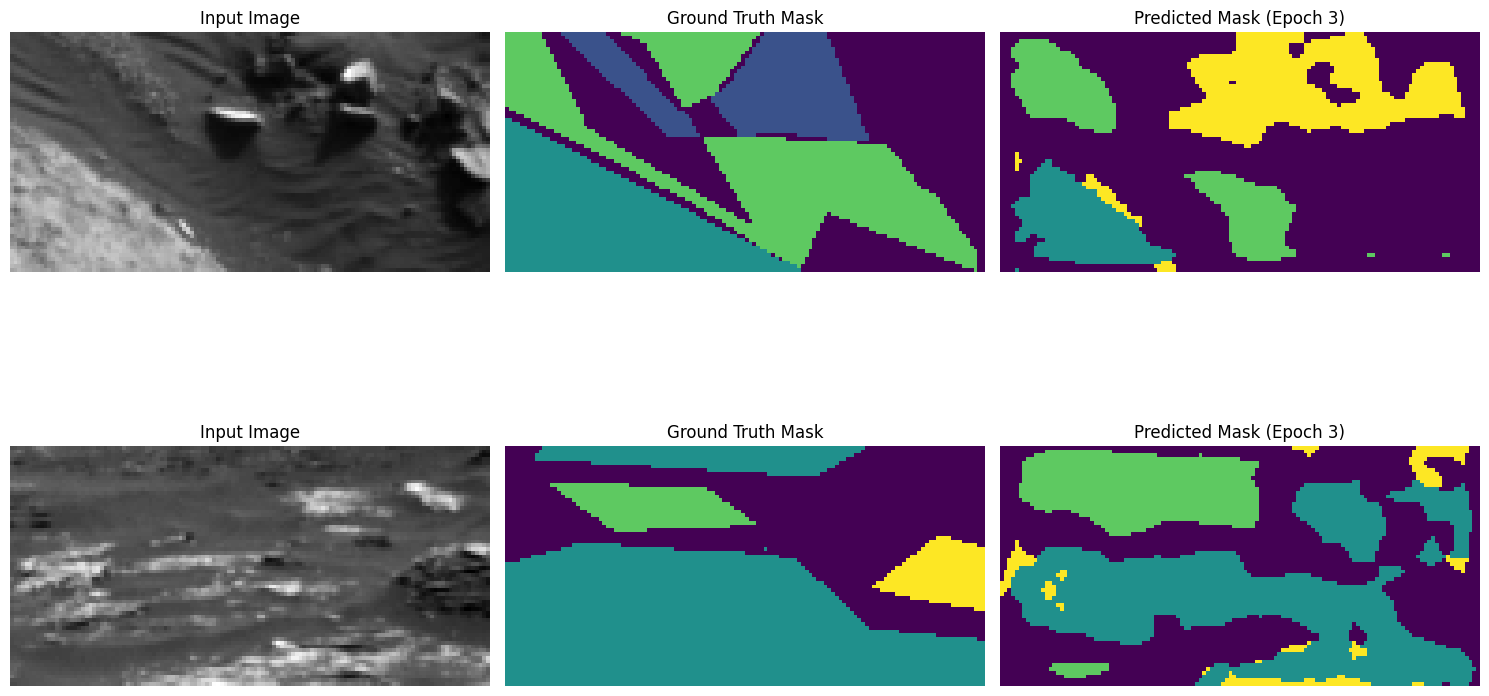

Model saved with new best Mean IoU: 0.3825
Model saved with new best Validation Accuracy: 0.6122
Model saved with new best Validation Loss: 7.1777
Epoch 4/50, Train Loss: 398.8409, Val Loss: 7.1484, Mean IoU: 0.4014, Val Accuracy: 0.6360
Class 0 IoU: 0.6005
Class 1 IoU: 0.3940
Class 2 IoU: 0.5774
Class 3 IoU: 0.0337


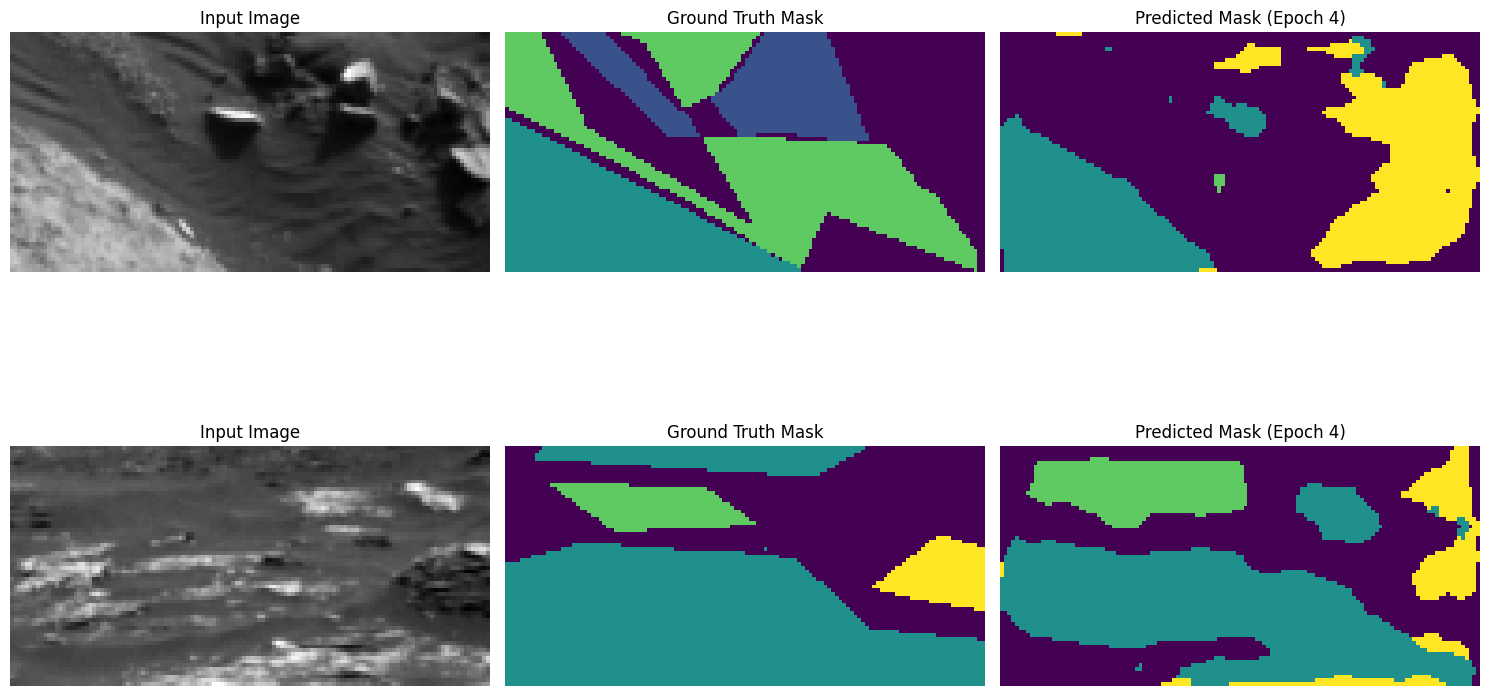

Model saved with new best Mean IoU: 0.4014
Model saved with new best Validation Accuracy: 0.6360
Model saved with new best Validation Loss: 7.1484
Epoch 5/50, Train Loss: 369.6897, Val Loss: 7.0726, Mean IoU: 0.4017, Val Accuracy: 0.6522
Class 0 IoU: 0.6090
Class 1 IoU: 0.4130
Class 2 IoU: 0.5557
Class 3 IoU: 0.0289


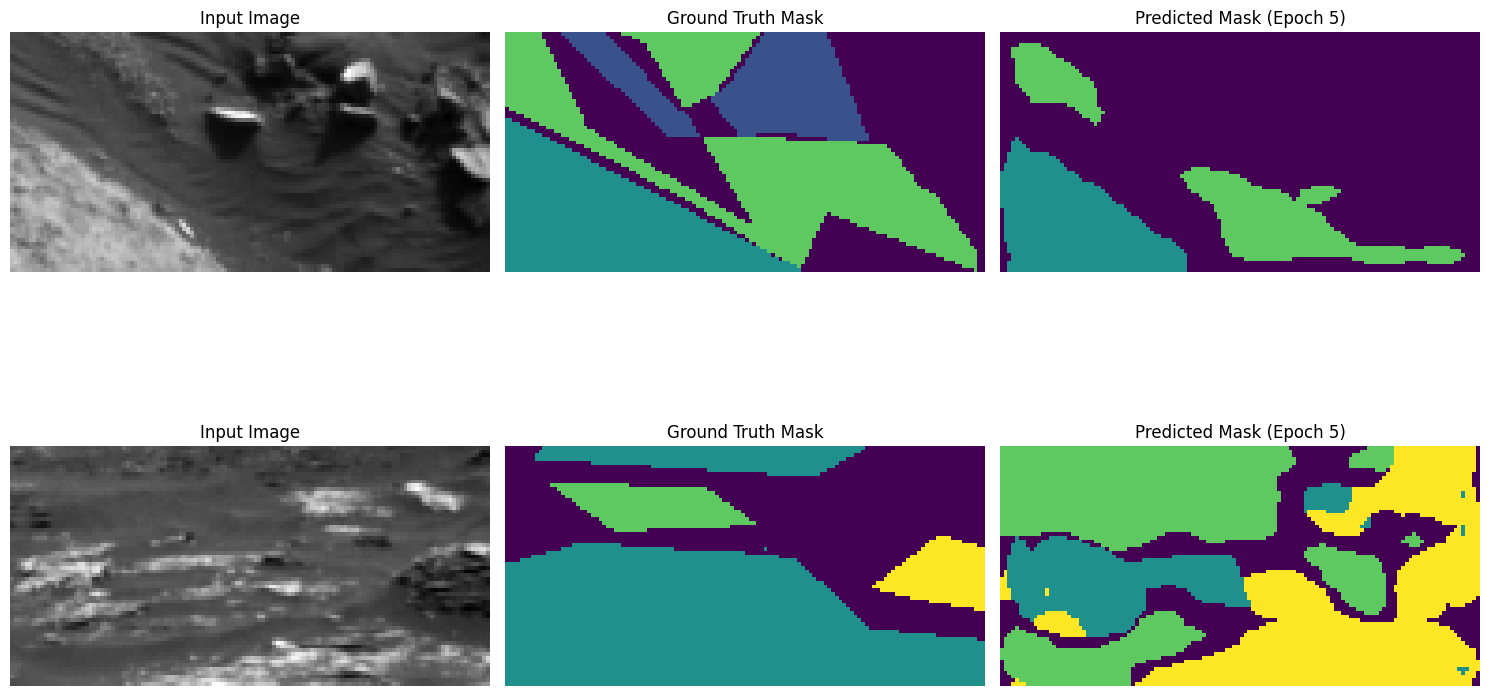

Model saved with new best Mean IoU: 0.4017
Model saved with new best Validation Accuracy: 0.6522
Model saved with new best Validation Loss: 7.0726
Epoch 6/50, Train Loss: 332.1864, Val Loss: 8.3352, Mean IoU: 0.4138, Val Accuracy: 0.6484
Class 0 IoU: 0.5927
Class 1 IoU: 0.5001
Class 2 IoU: 0.5539
Class 3 IoU: 0.0087


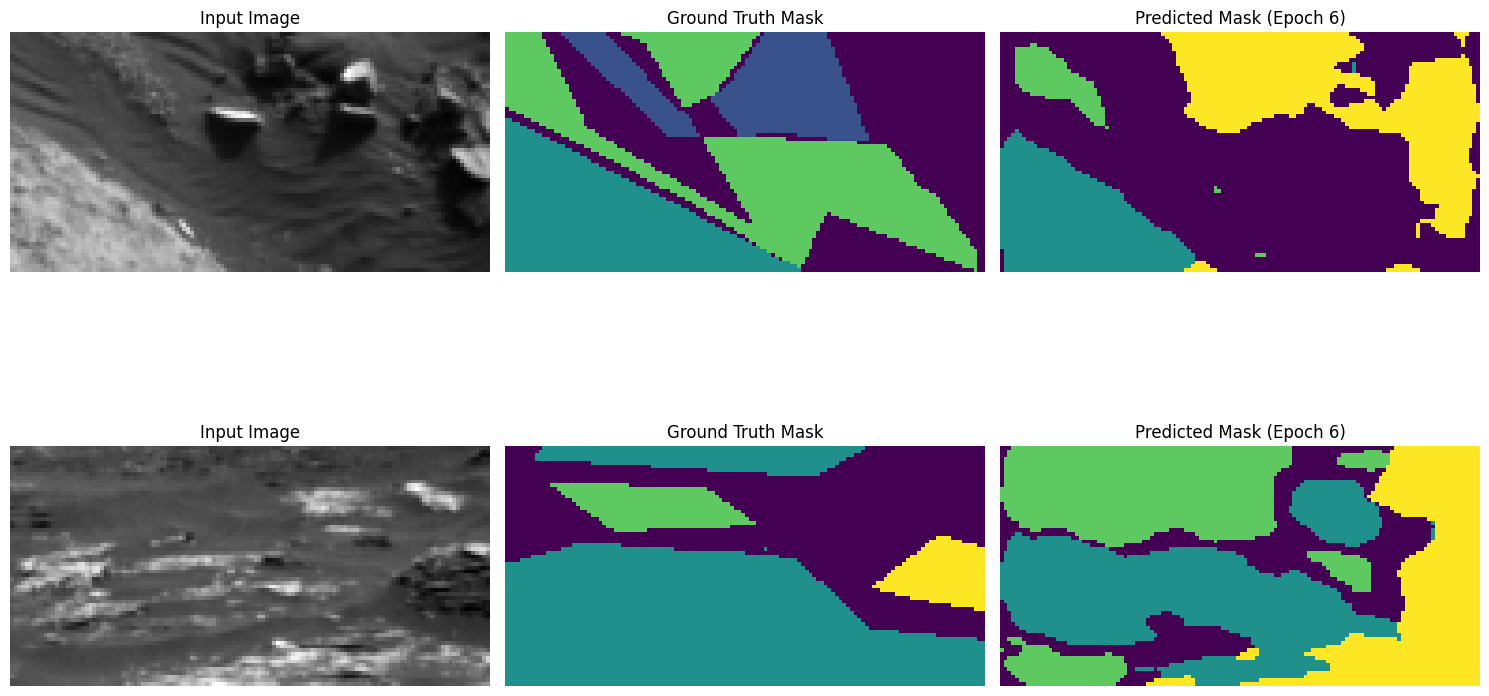

Model saved with new best Mean IoU: 0.4138
Epoch 7/50, Train Loss: 314.2228, Val Loss: 8.2335, Mean IoU: 0.4458, Val Accuracy: 0.6926
Class 0 IoU: 0.6479
Class 1 IoU: 0.5119
Class 2 IoU: 0.5944
Class 3 IoU: 0.0291


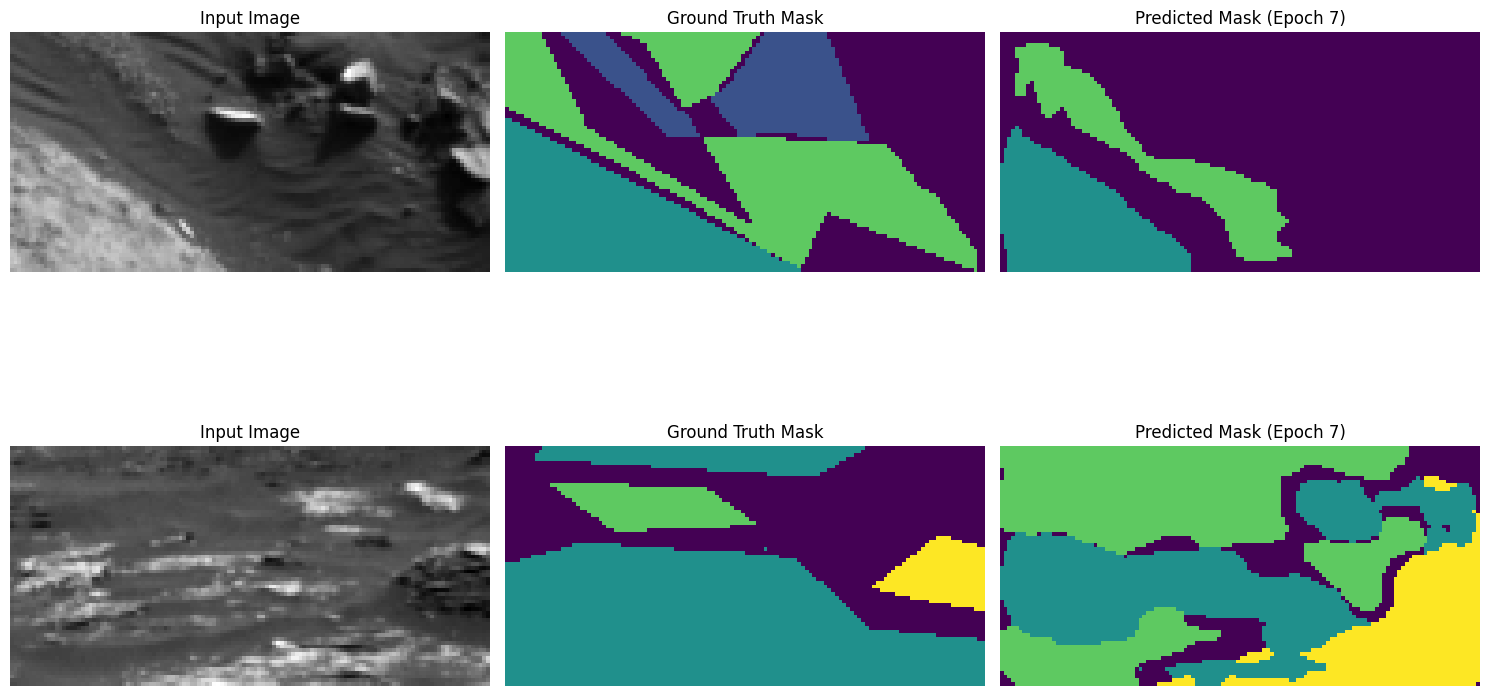

Model saved with new best Mean IoU: 0.4458
Model saved with new best Validation Accuracy: 0.6926
Epoch 8/50, Train Loss: 291.8502, Val Loss: 8.7389, Mean IoU: 0.4364, Val Accuracy: 0.6838
Class 0 IoU: 0.6129
Class 1 IoU: 0.4907
Class 2 IoU: 0.6023
Class 3 IoU: 0.0395


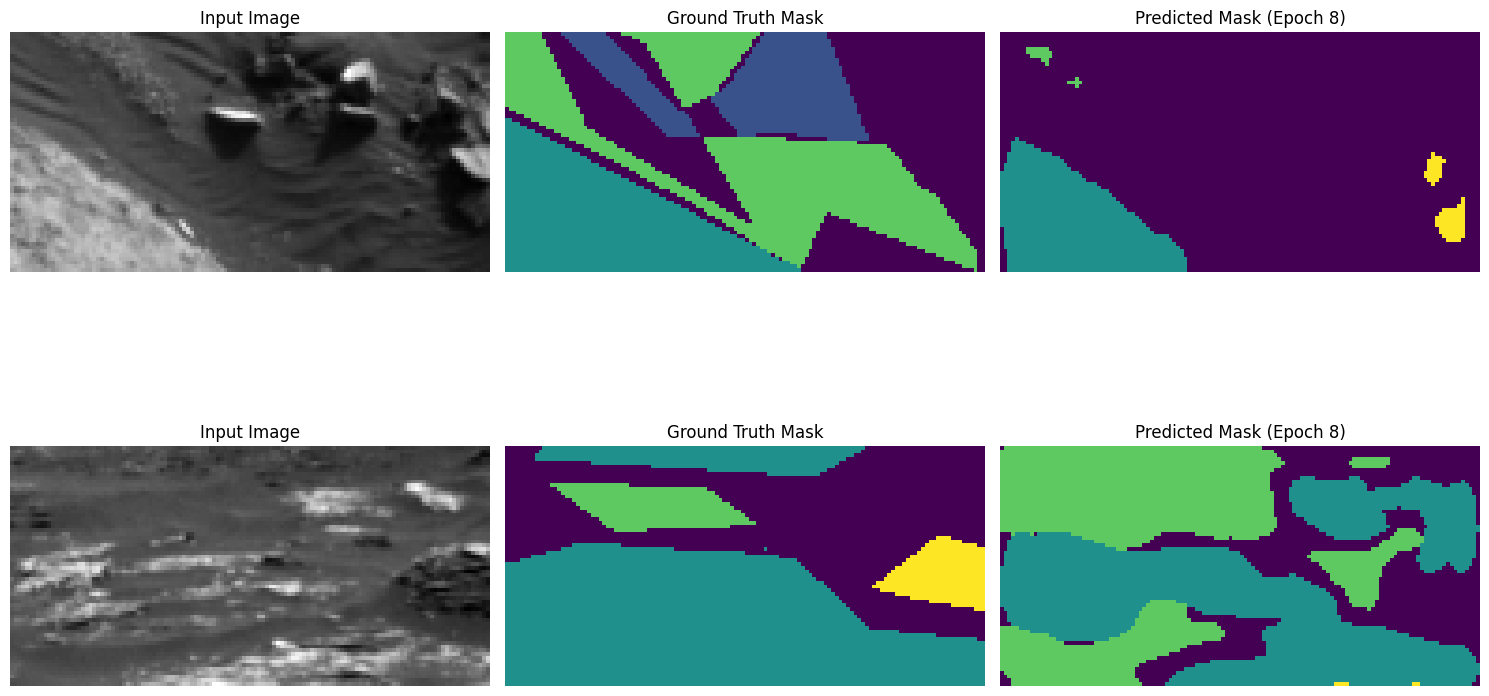

Epoch 9/50, Train Loss: 301.9729, Val Loss: 6.8707, Mean IoU: 0.4361, Val Accuracy: 0.6831
Class 0 IoU: 0.6388
Class 1 IoU: 0.4350
Class 2 IoU: 0.6146
Class 3 IoU: 0.0560


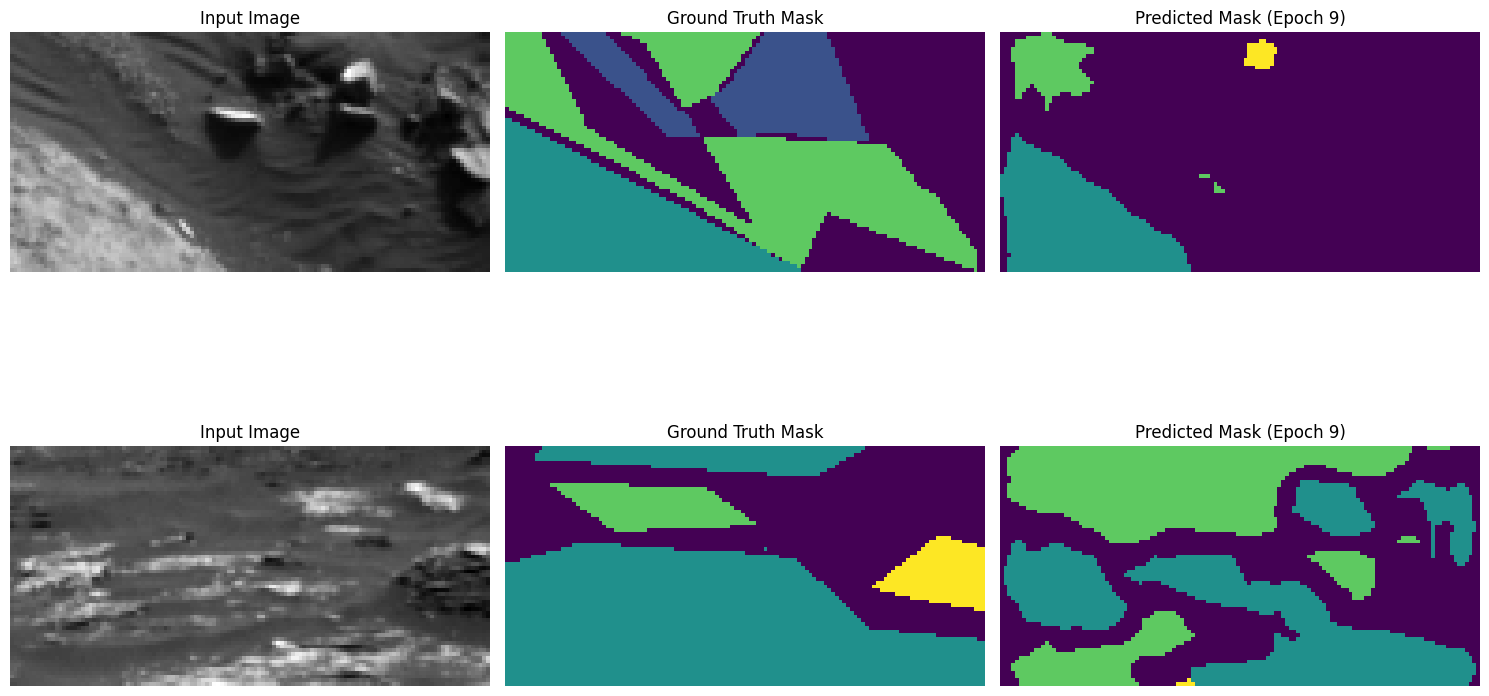

Model saved with new best Validation Loss: 6.8707
Epoch 10/50, Train Loss: 274.5250, Val Loss: 7.5907, Mean IoU: 0.4401, Val Accuracy: 0.6847
Class 0 IoU: 0.6215
Class 1 IoU: 0.4991
Class 2 IoU: 0.5935
Class 3 IoU: 0.0462


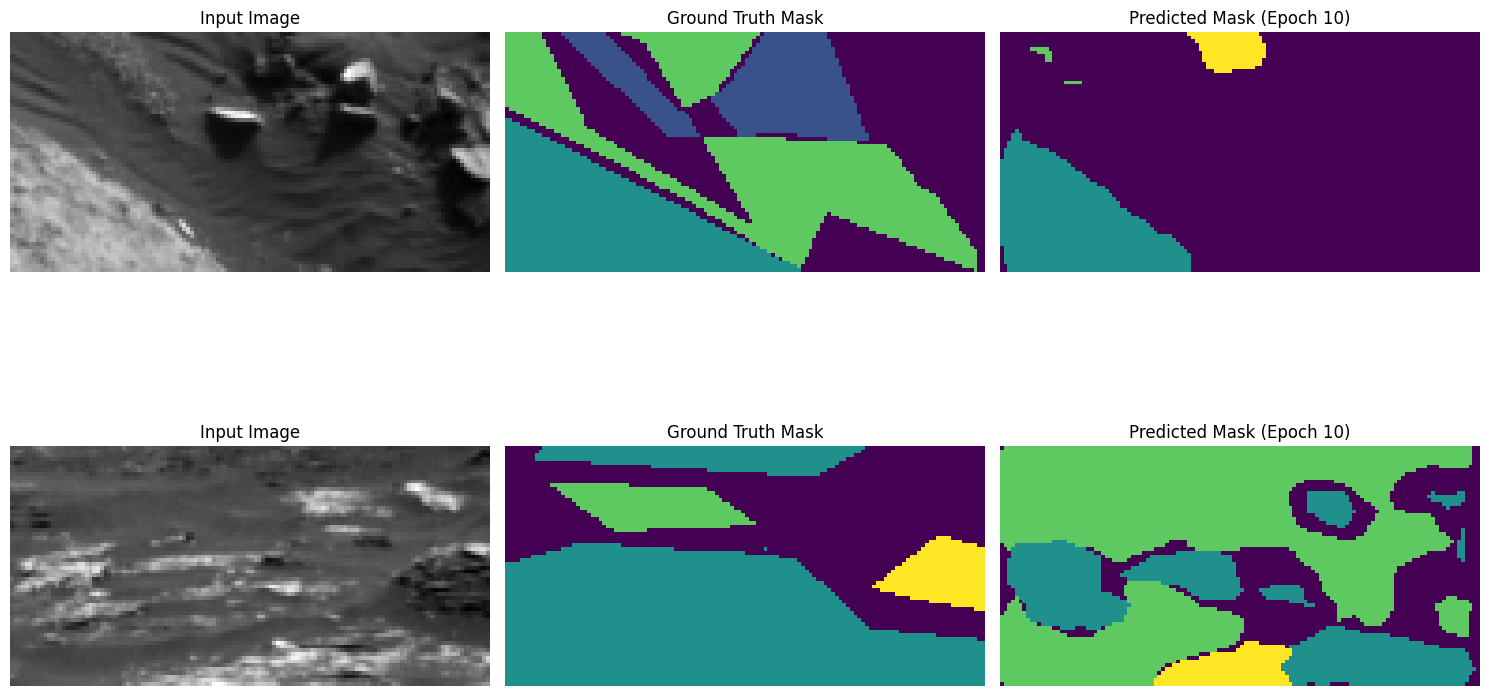

Epoch 11/50, Train Loss: 245.4260, Val Loss: 8.4403, Mean IoU: 0.4708, Val Accuracy: 0.7079
Class 0 IoU: 0.6752
Class 1 IoU: 0.5421
Class 2 IoU: 0.6038
Class 3 IoU: 0.0620


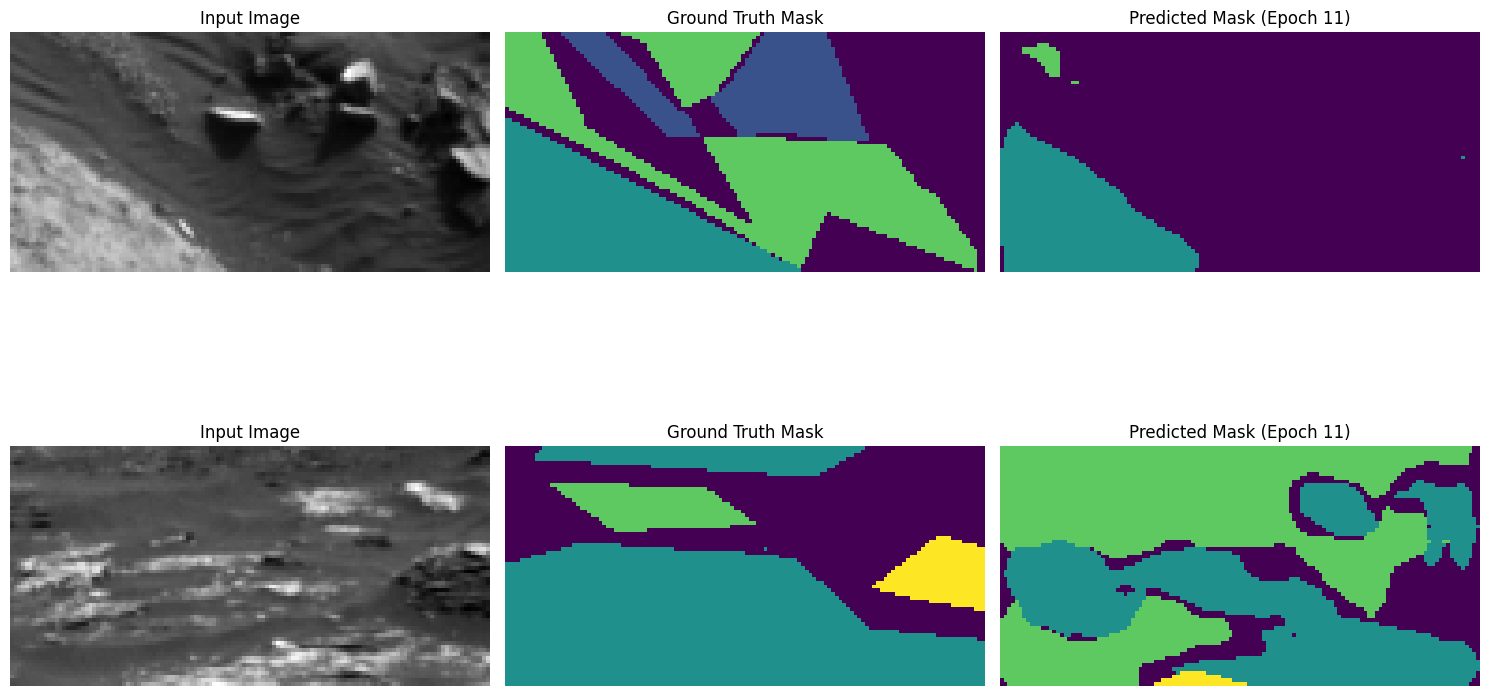

Model saved with new best Mean IoU: 0.4708
Model saved with new best Validation Accuracy: 0.7079
Epoch 12/50, Train Loss: 228.9696, Val Loss: 8.2883, Mean IoU: 0.4808, Val Accuracy: 0.7063
Class 0 IoU: 0.6579
Class 1 IoU: 0.5079
Class 2 IoU: 0.6259
Class 3 IoU: 0.1313


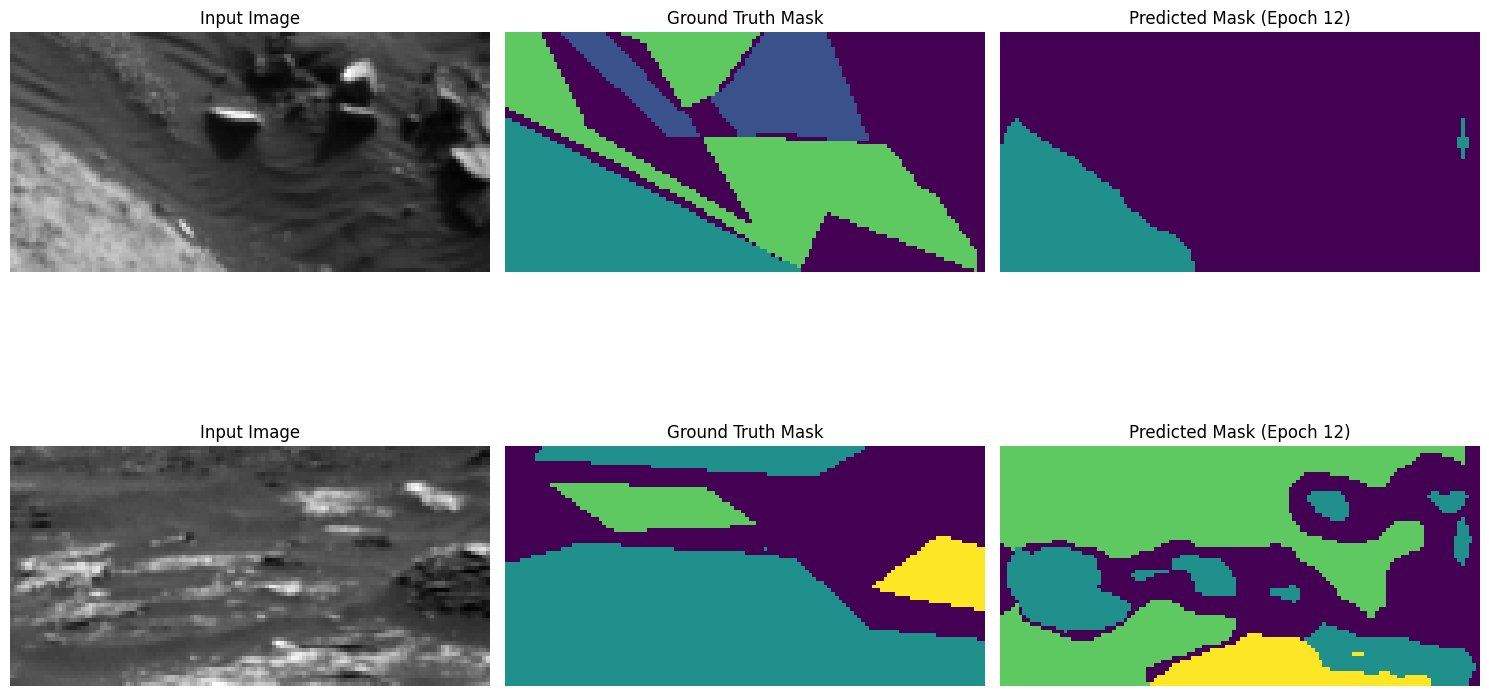

Model saved with new best Mean IoU: 0.4808
Epoch 13/50, Train Loss: 220.9422, Val Loss: 8.9052, Mean IoU: 0.4527, Val Accuracy: 0.6827
Class 0 IoU: 0.6282
Class 1 IoU: 0.5177
Class 2 IoU: 0.5832
Class 3 IoU: 0.0818


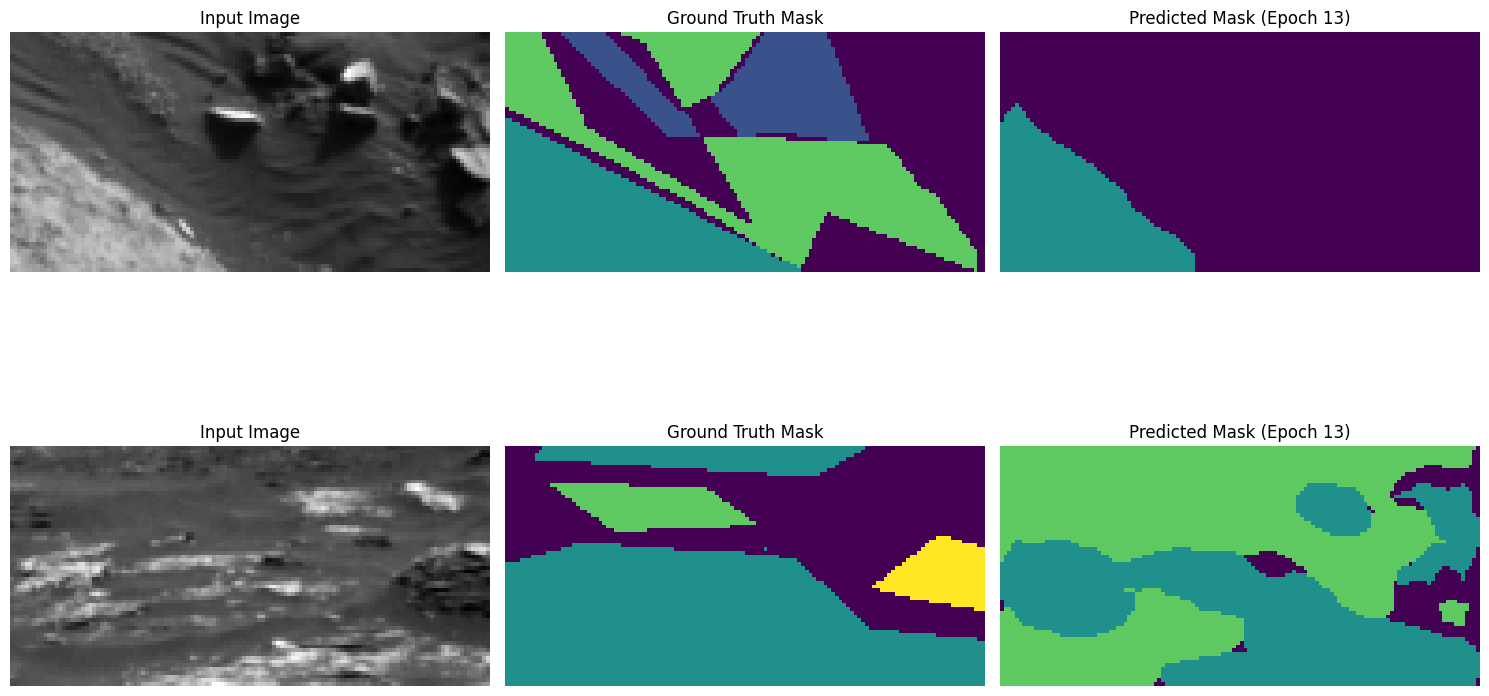

Epoch 14/50, Train Loss: 203.2102, Val Loss: 11.6173, Mean IoU: 0.4147, Val Accuracy: 0.6798
Class 0 IoU: 0.6596
Class 1 IoU: 0.3620
Class 2 IoU: 0.6142
Class 3 IoU: 0.0232


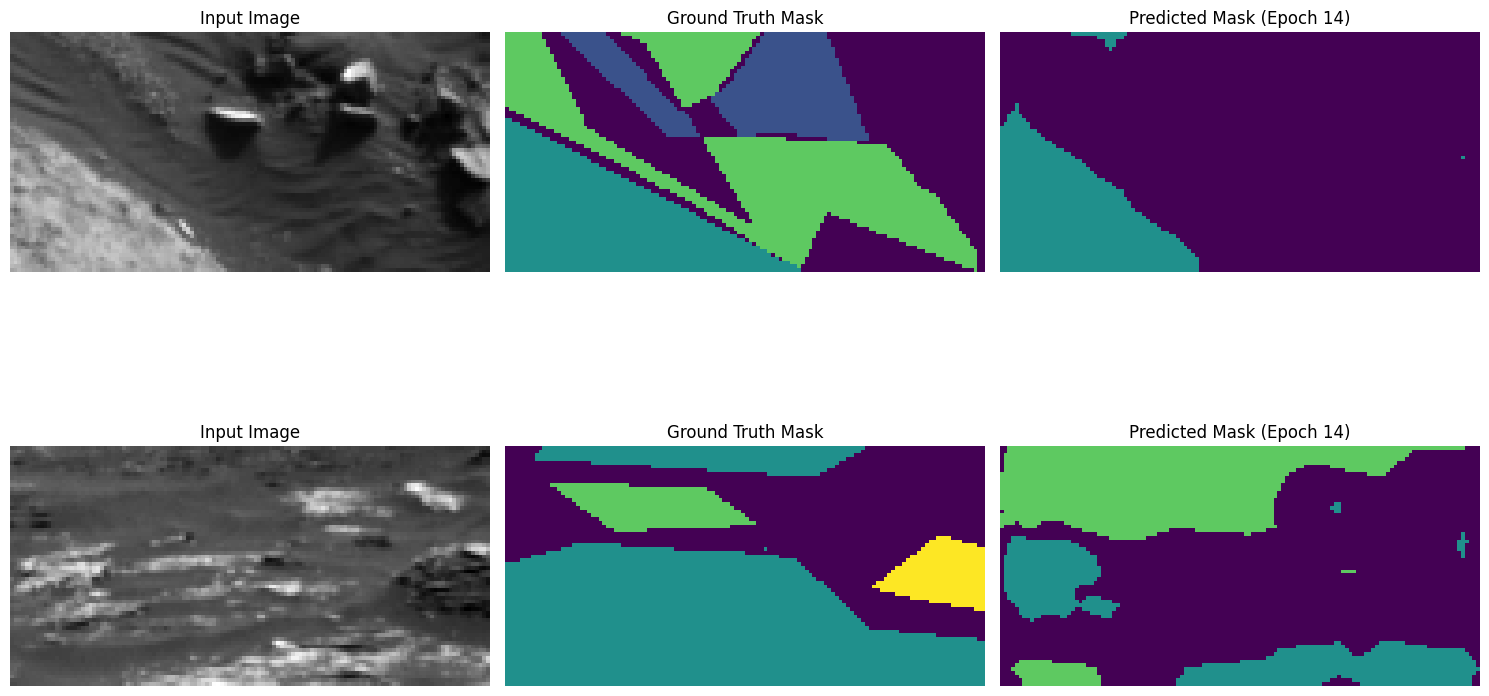

Epoch 15/50, Train Loss: 191.3284, Val Loss: 8.8947, Mean IoU: 0.4516, Val Accuracy: 0.6812
Class 0 IoU: 0.6283
Class 1 IoU: 0.5179
Class 2 IoU: 0.6003
Class 3 IoU: 0.0599


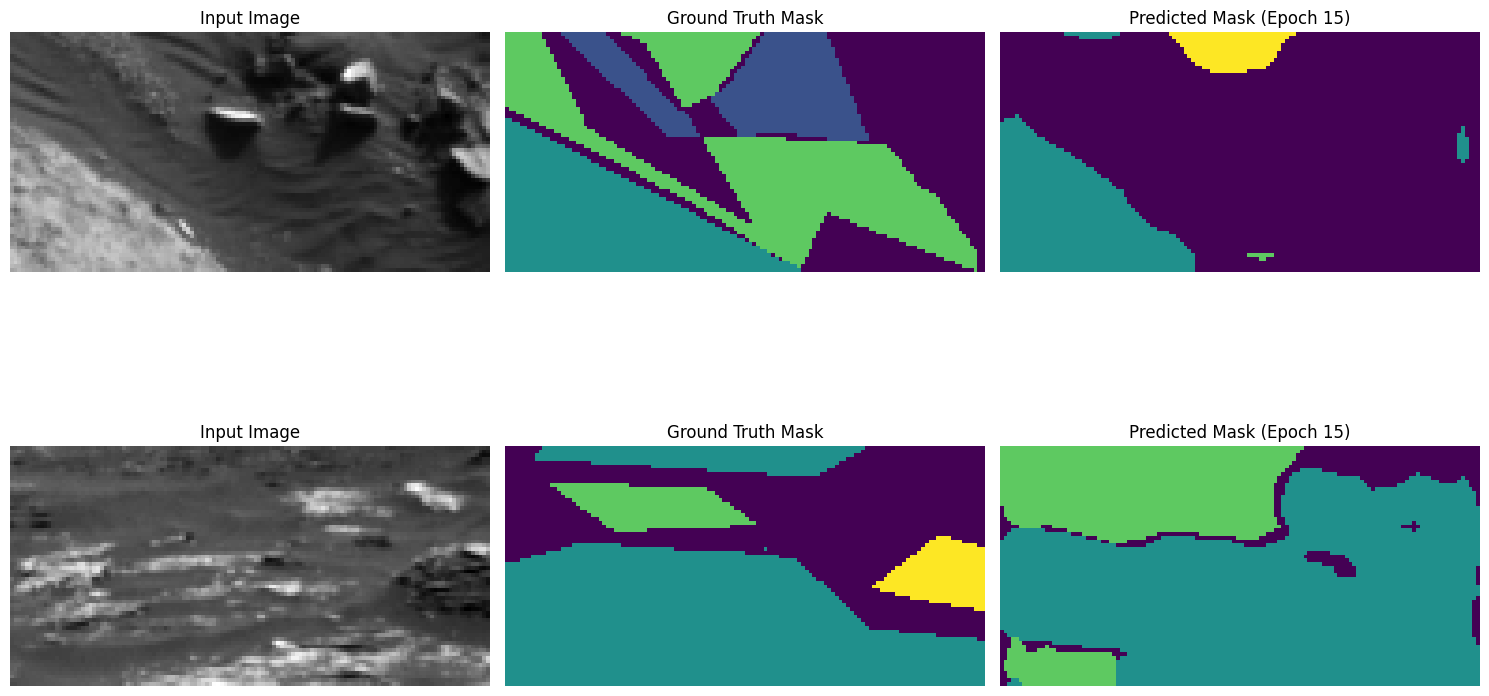

Epoch 16/50, Train Loss: 165.1061, Val Loss: 10.0770, Mean IoU: 0.4911, Val Accuracy: 0.7214
Class 0 IoU: 0.6975
Class 1 IoU: 0.5367
Class 2 IoU: 0.6399
Class 3 IoU: 0.0903


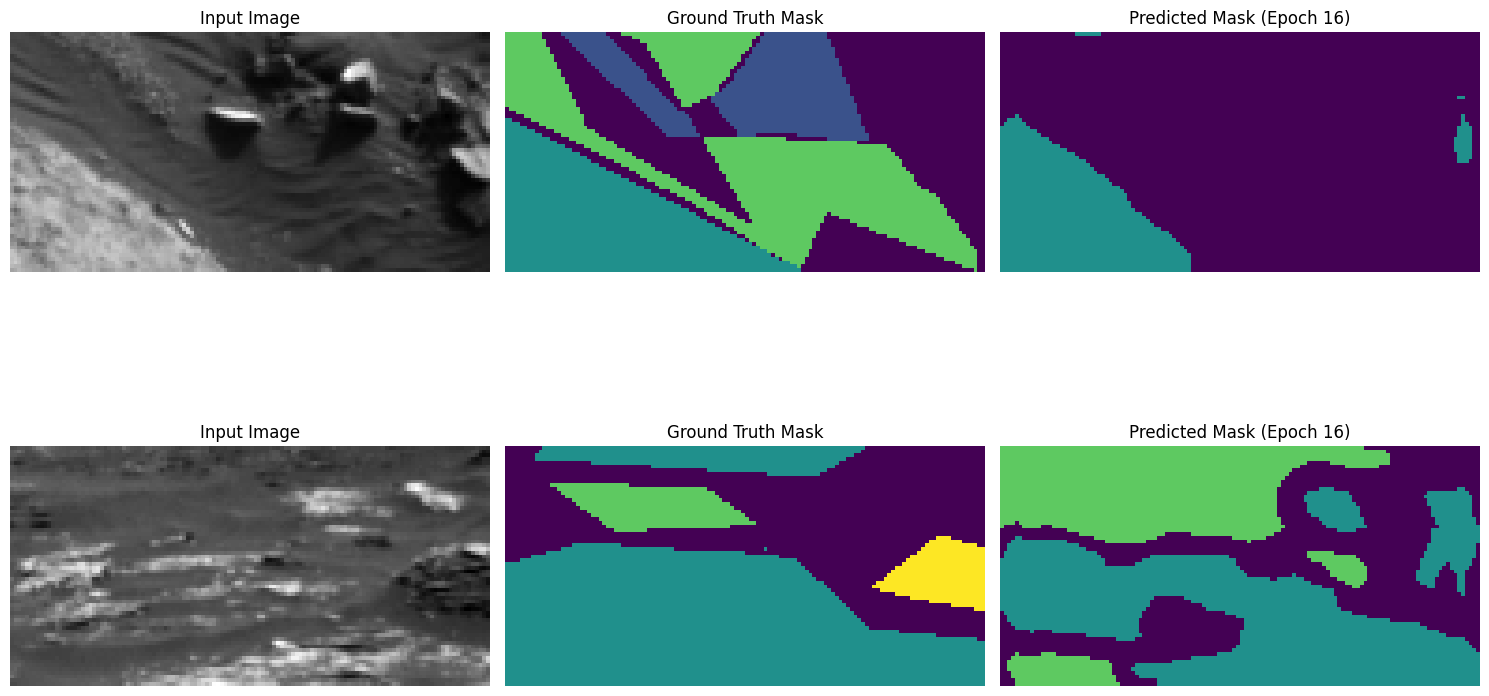

Model saved with new best Mean IoU: 0.4911
Model saved with new best Validation Accuracy: 0.7214
Epoch 17/50, Train Loss: 153.8696, Val Loss: 11.0872, Mean IoU: 0.4682, Val Accuracy: 0.7207
Class 0 IoU: 0.6796
Class 1 IoU: 0.5565
Class 2 IoU: 0.6071
Class 3 IoU: 0.0296


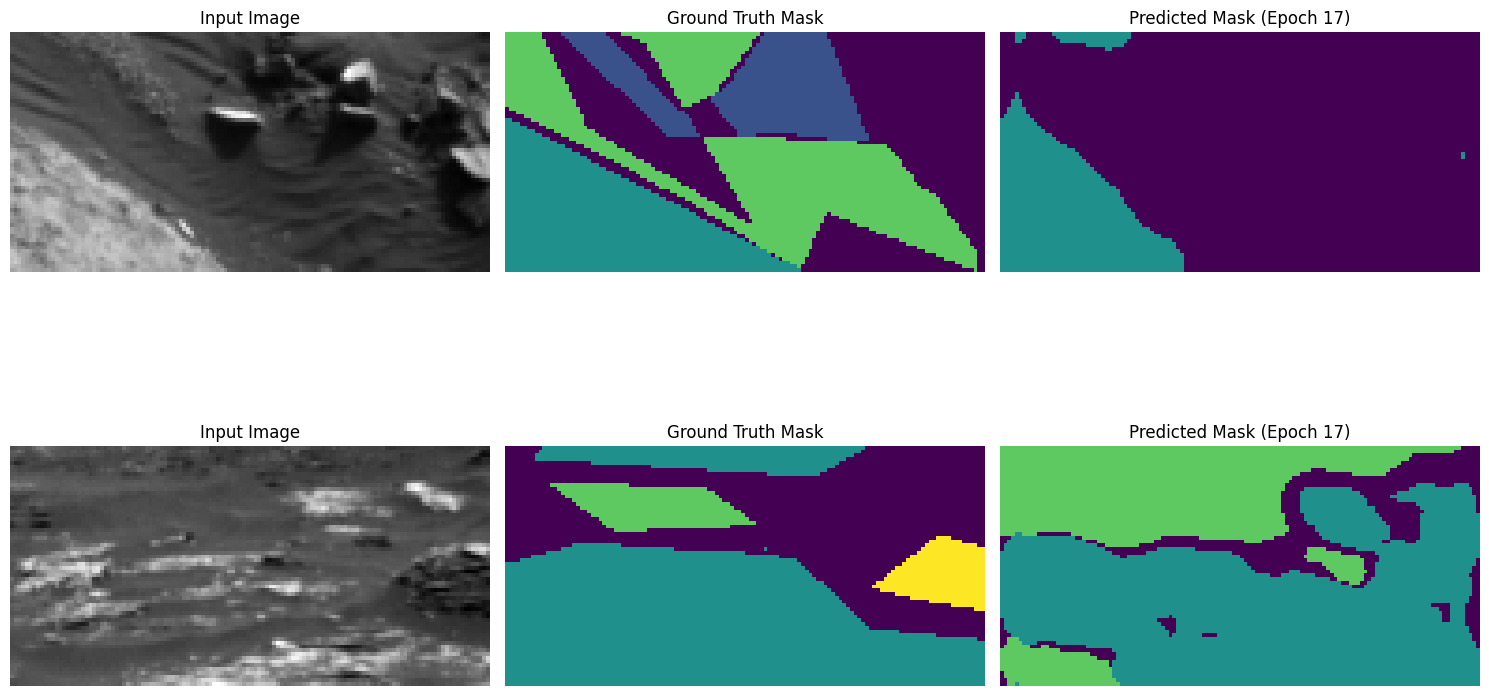

Epoch 18/50, Train Loss: 148.0781, Val Loss: 12.7599, Mean IoU: 0.3774, Val Accuracy: 0.6183
Class 0 IoU: 0.4471
Class 1 IoU: 0.4312
Class 2 IoU: 0.5695
Class 3 IoU: 0.0617


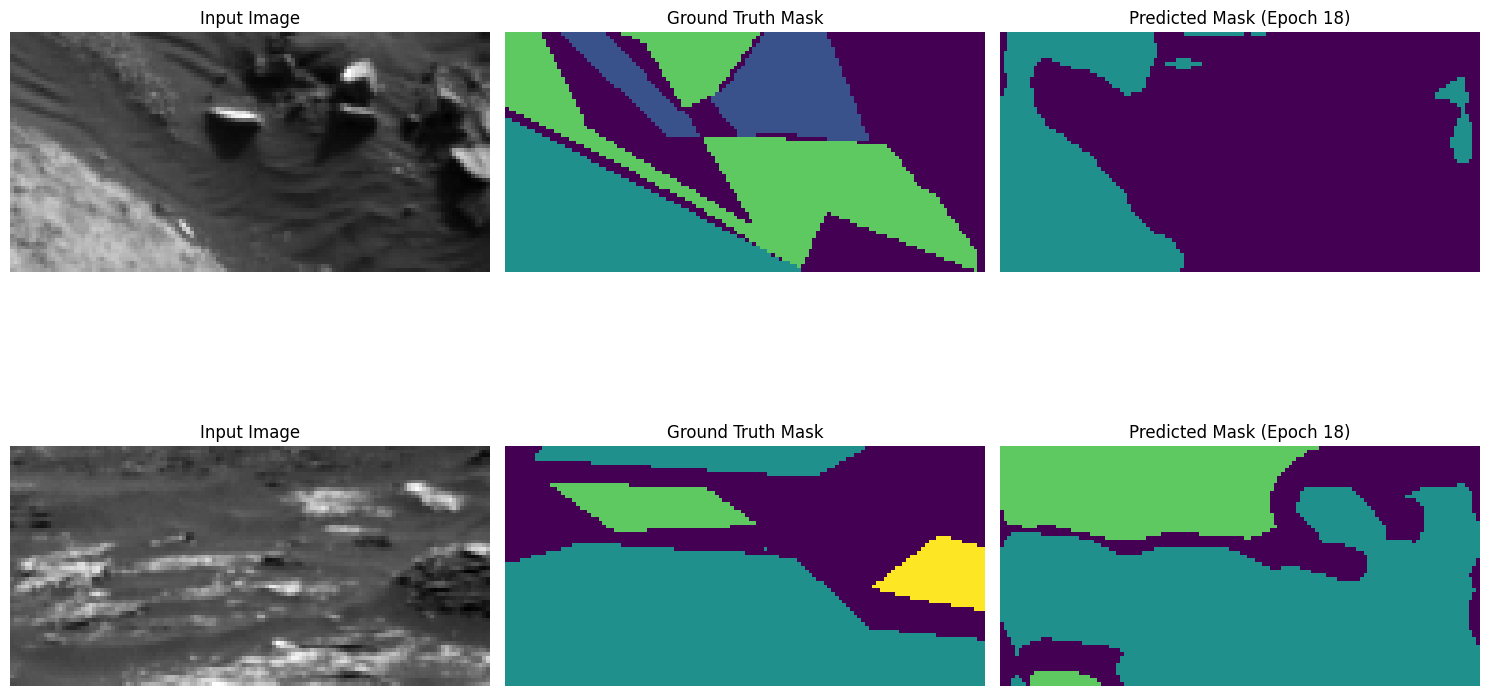

Epoch 19/50, Train Loss: 138.9702, Val Loss: 11.2926, Mean IoU: 0.4738, Val Accuracy: 0.6904
Class 0 IoU: 0.6439
Class 1 IoU: 0.5193
Class 2 IoU: 0.6000
Class 3 IoU: 0.1322


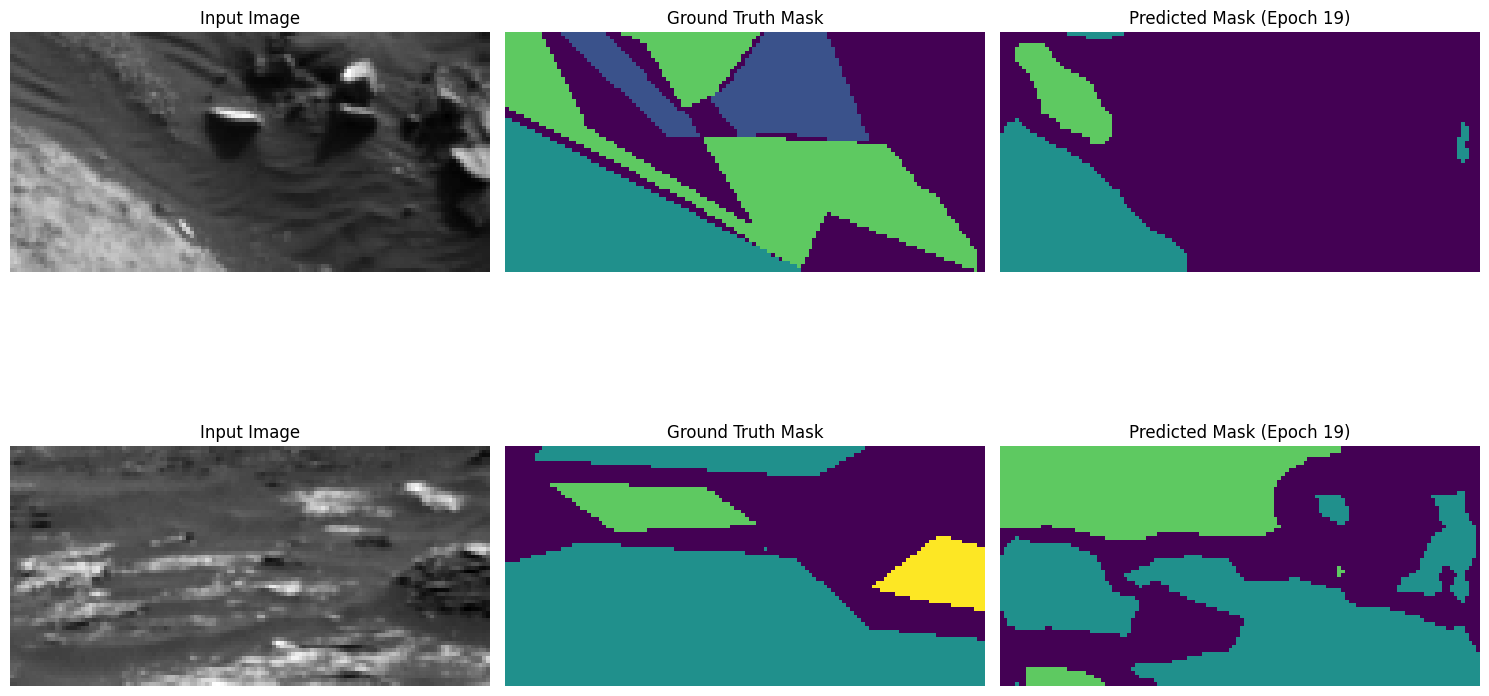

Epoch 20/50, Train Loss: 131.4821, Val Loss: 12.1030, Mean IoU: 0.4659, Val Accuracy: 0.7086
Class 0 IoU: 0.6618
Class 1 IoU: 0.5322
Class 2 IoU: 0.6396
Class 3 IoU: 0.0299


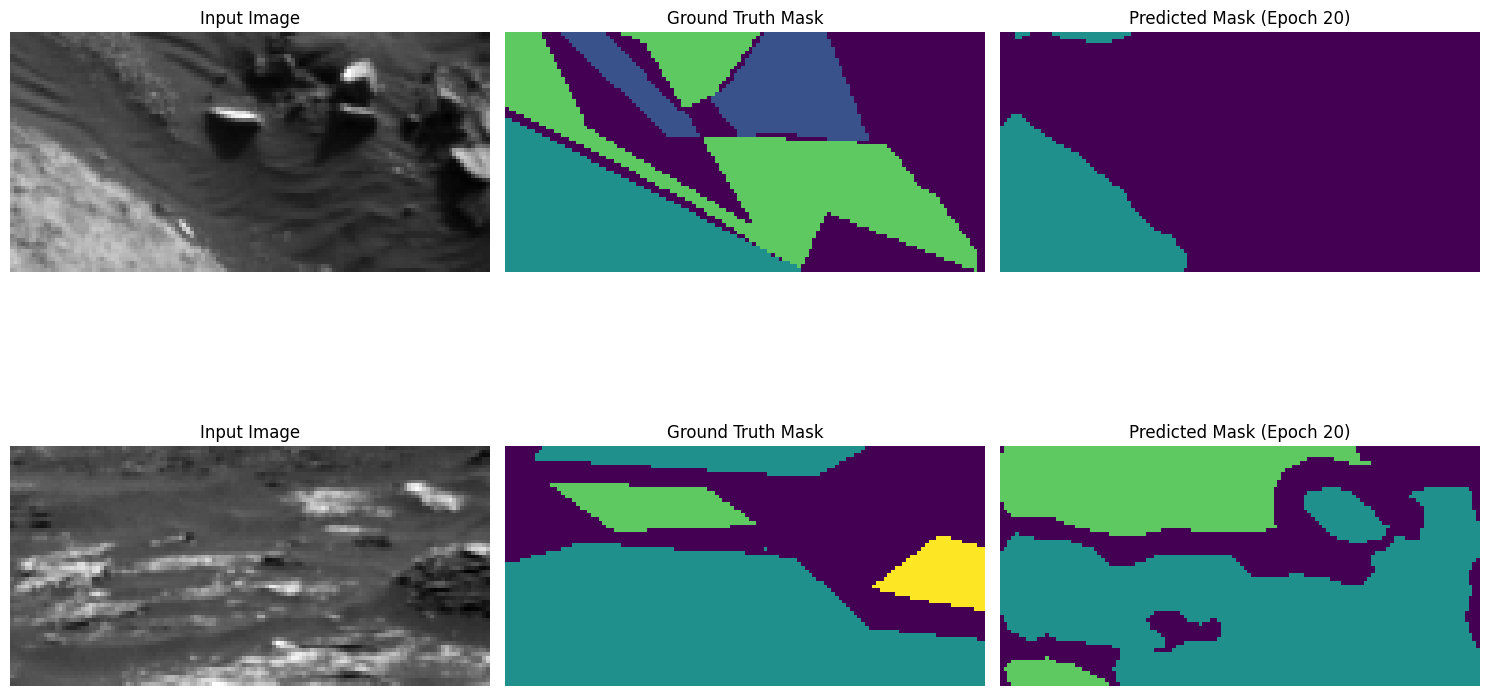

Epoch 21/50, Train Loss: 126.6433, Val Loss: 11.6535, Mean IoU: 0.4721, Val Accuracy: 0.7117
Class 0 IoU: 0.6679
Class 1 IoU: 0.5248
Class 2 IoU: 0.6352
Class 3 IoU: 0.0605


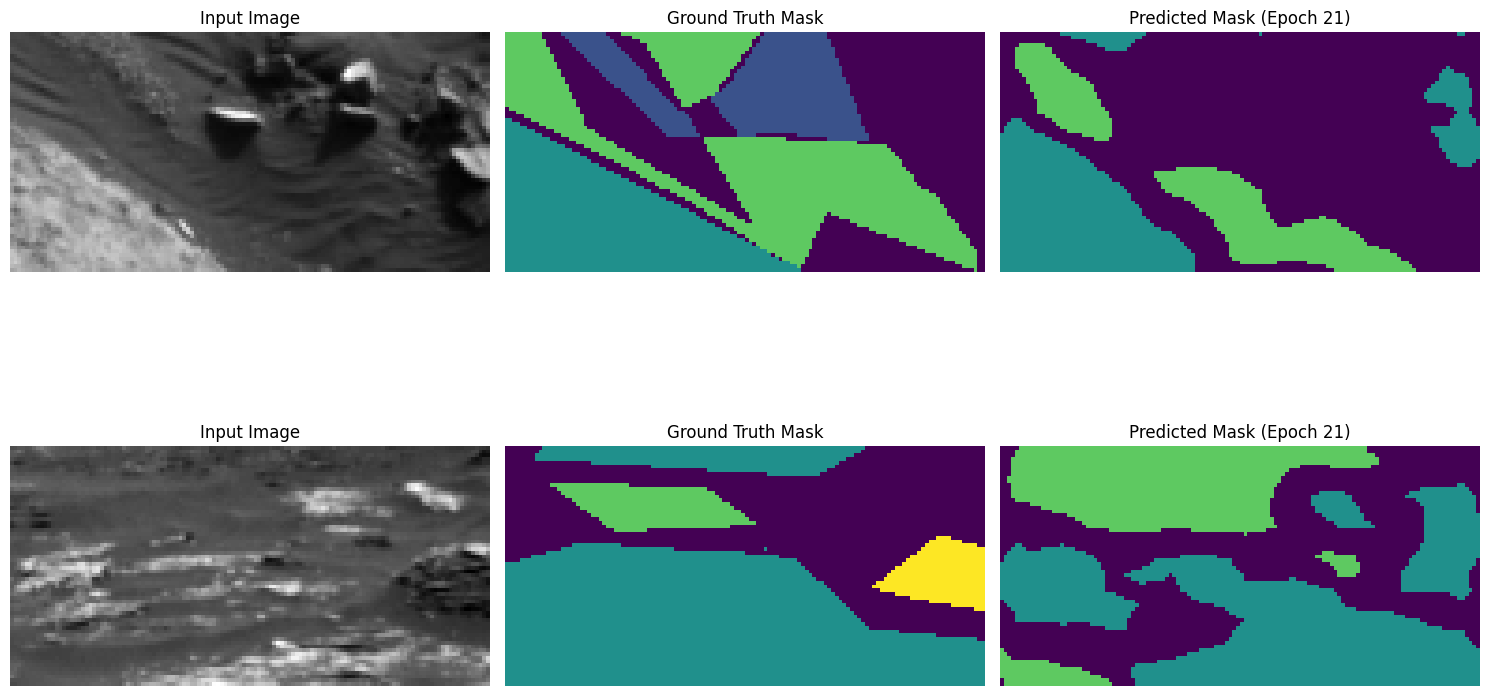

Epoch 22/50, Train Loss: 112.3397, Val Loss: 12.0733, Mean IoU: 0.4670, Val Accuracy: 0.7199
Class 0 IoU: 0.6865
Class 1 IoU: 0.5396
Class 2 IoU: 0.6248
Class 3 IoU: 0.0171


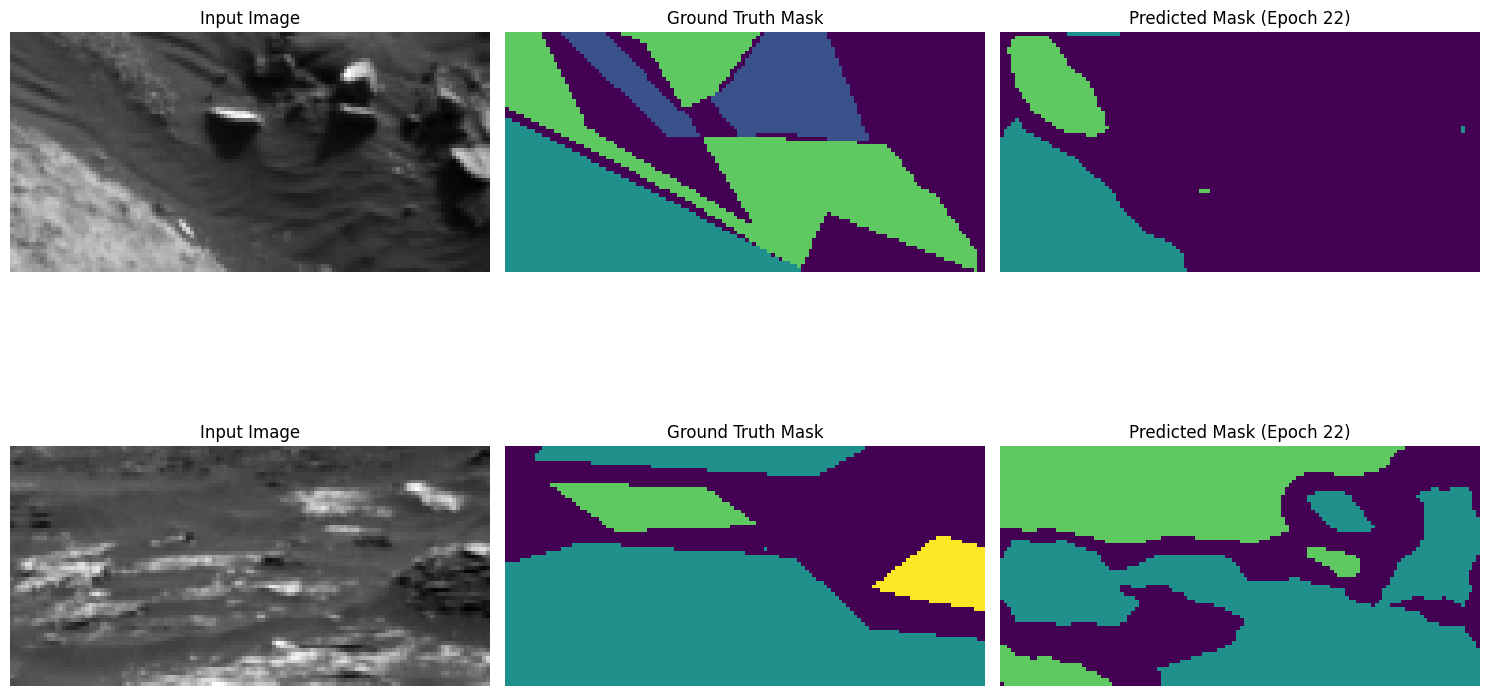

Epoch 23/50, Train Loss: 107.4398, Val Loss: 12.8354, Mean IoU: 0.4531, Val Accuracy: 0.7067
Class 0 IoU: 0.6623
Class 1 IoU: 0.5311
Class 2 IoU: 0.6167
Class 3 IoU: 0.0023


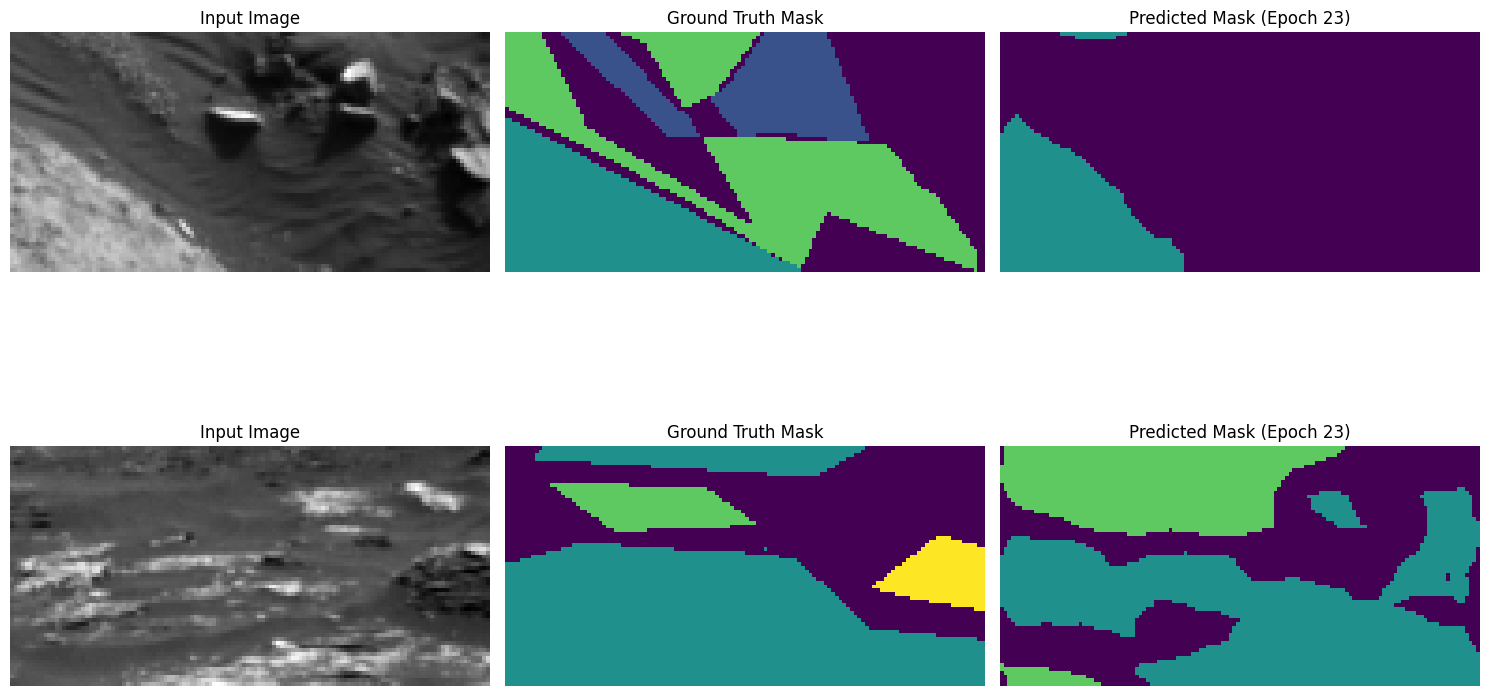

Epoch 24/50, Train Loss: 102.1991, Val Loss: 13.7703, Mean IoU: 0.4450, Val Accuracy: 0.6988
Class 0 IoU: 0.6343
Class 1 IoU: 0.5287
Class 2 IoU: 0.6171
Class 3 IoU: 0.0000


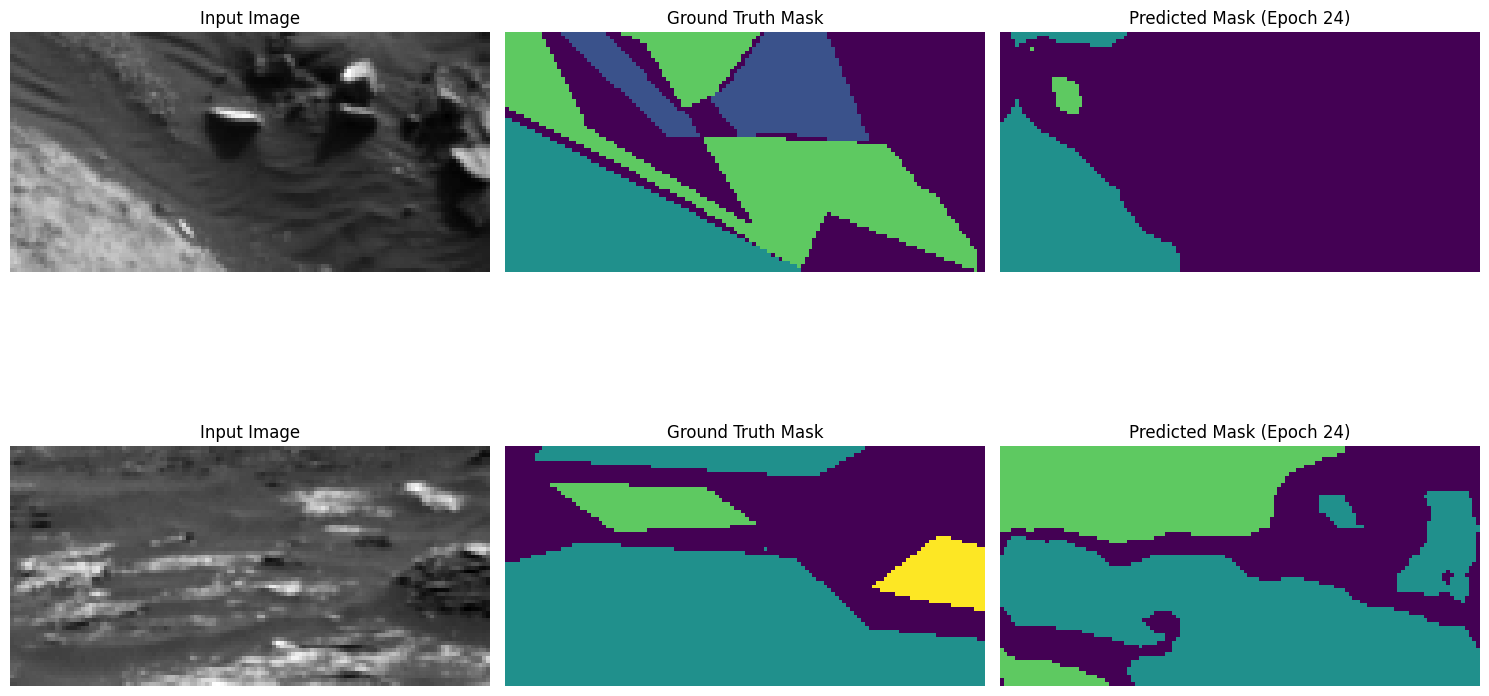

Epoch 25/50, Train Loss: 98.6655, Val Loss: 13.3085, Mean IoU: 0.4639, Val Accuracy: 0.7097
Class 0 IoU: 0.6845
Class 1 IoU: 0.5242
Class 2 IoU: 0.6075
Class 3 IoU: 0.0396


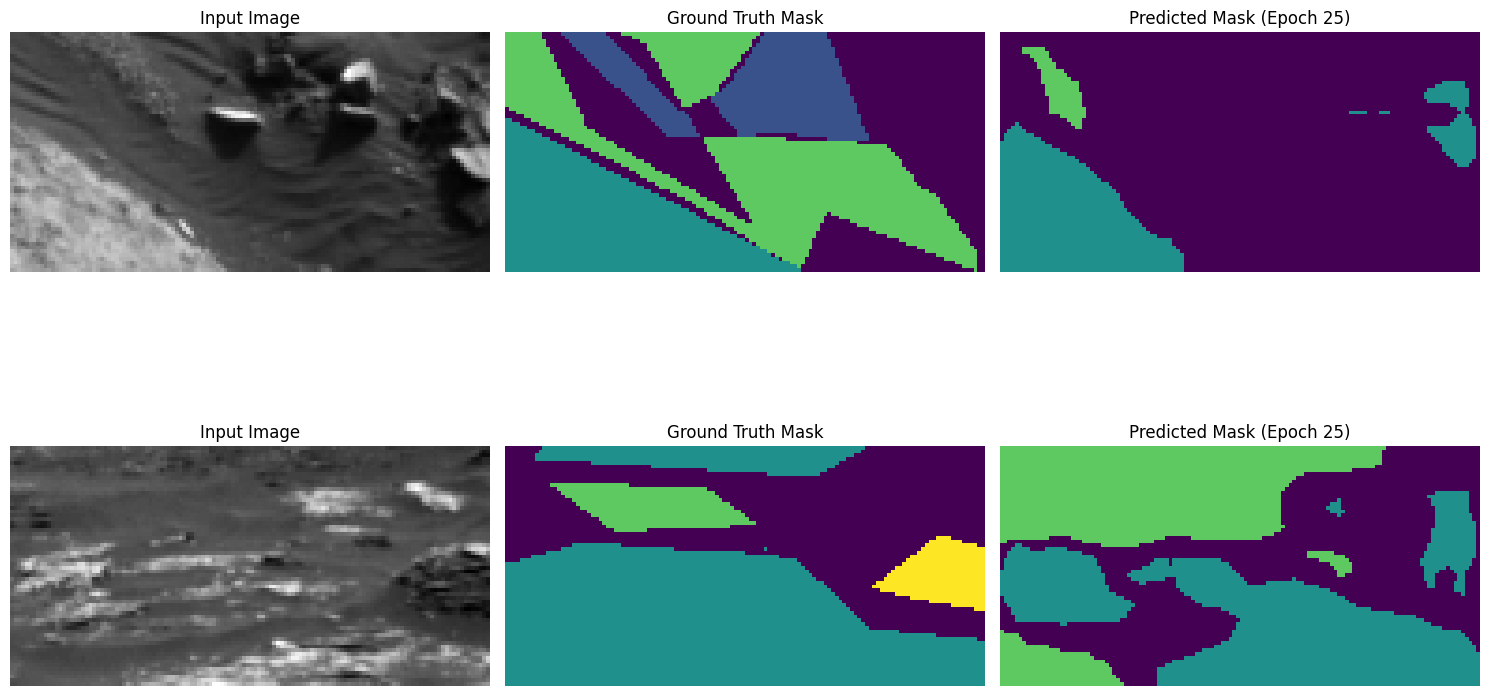

Epoch 26/50, Train Loss: 94.6672, Val Loss: 14.0792, Mean IoU: 0.4494, Val Accuracy: 0.7106
Class 0 IoU: 0.6701
Class 1 IoU: 0.5148
Class 2 IoU: 0.6129
Class 3 IoU: 0.0000


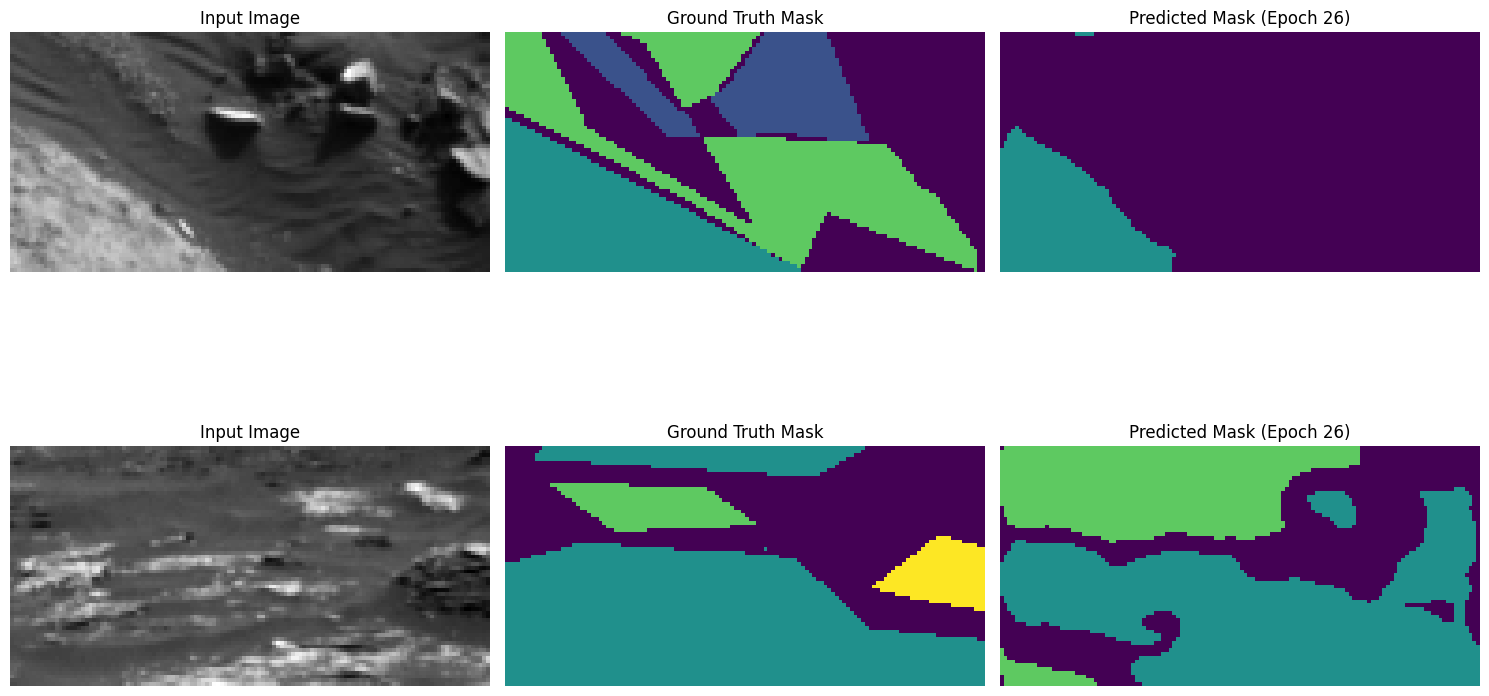

Epoch 27/50, Train Loss: 91.7748, Val Loss: 13.1137, Mean IoU: 0.4584, Val Accuracy: 0.7104
Class 0 IoU: 0.6744
Class 1 IoU: 0.5291
Class 2 IoU: 0.6148
Class 3 IoU: 0.0152


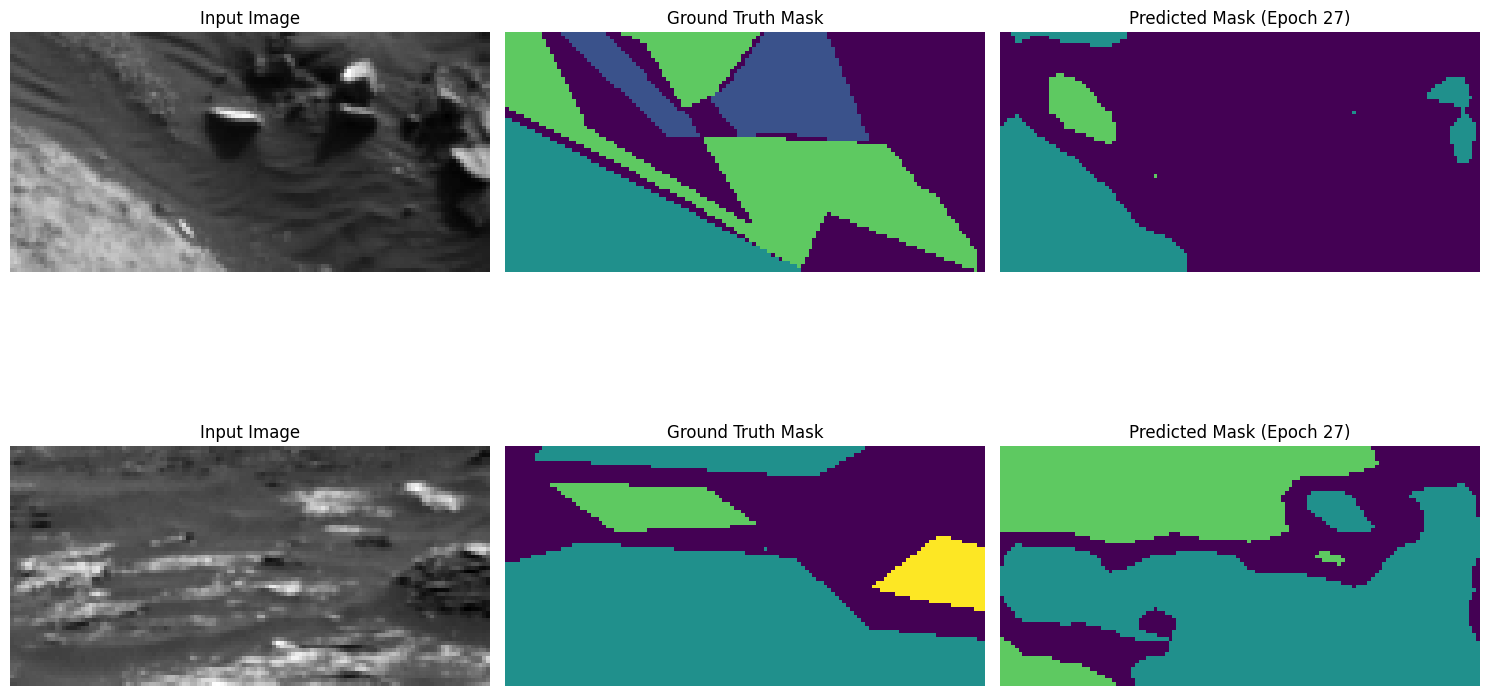

Epoch 28/50, Train Loss: 83.5687, Val Loss: 13.5512, Mean IoU: 0.4533, Val Accuracy: 0.7080
Class 0 IoU: 0.6715
Class 1 IoU: 0.5270
Class 2 IoU: 0.6060
Class 3 IoU: 0.0086


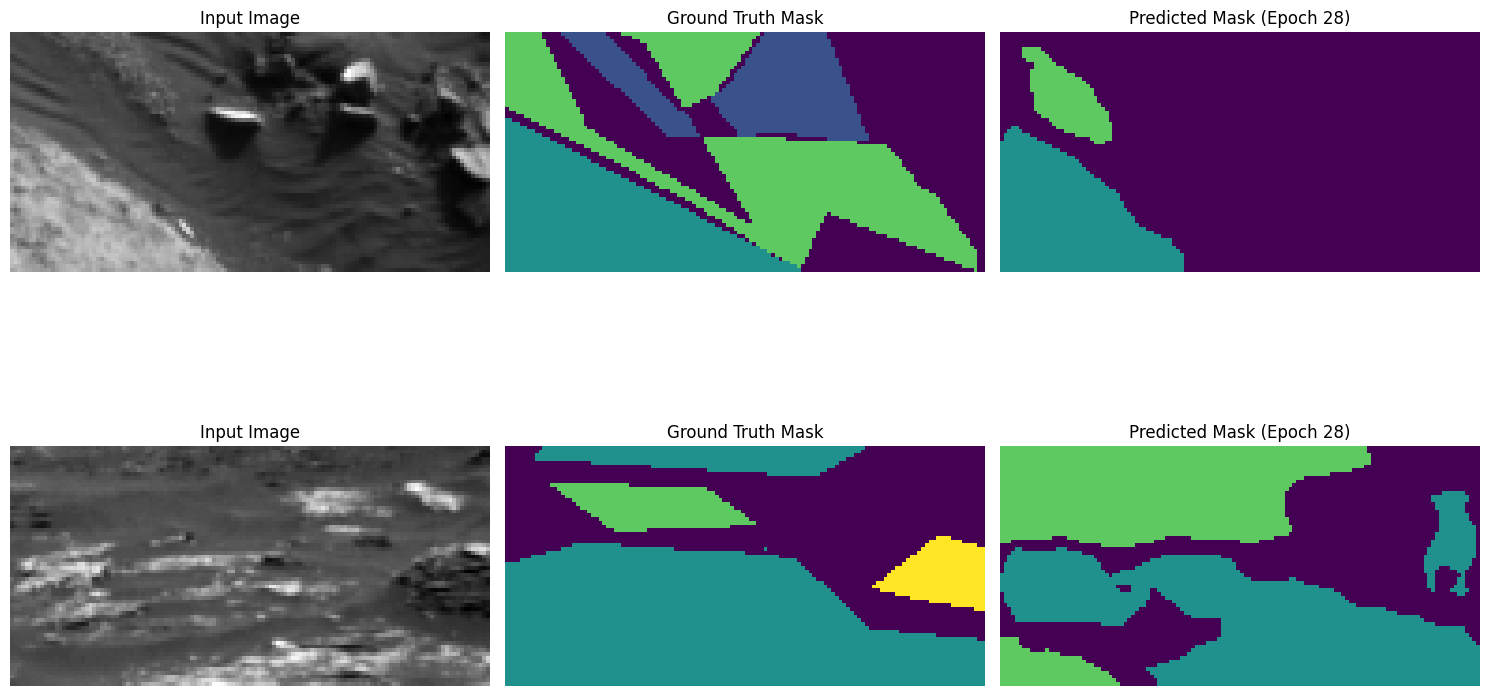

Epoch 29/50, Train Loss: 80.8193, Val Loss: 13.9722, Mean IoU: 0.4592, Val Accuracy: 0.7139
Class 0 IoU: 0.6794
Class 1 IoU: 0.5373
Class 2 IoU: 0.6194
Class 3 IoU: 0.0008


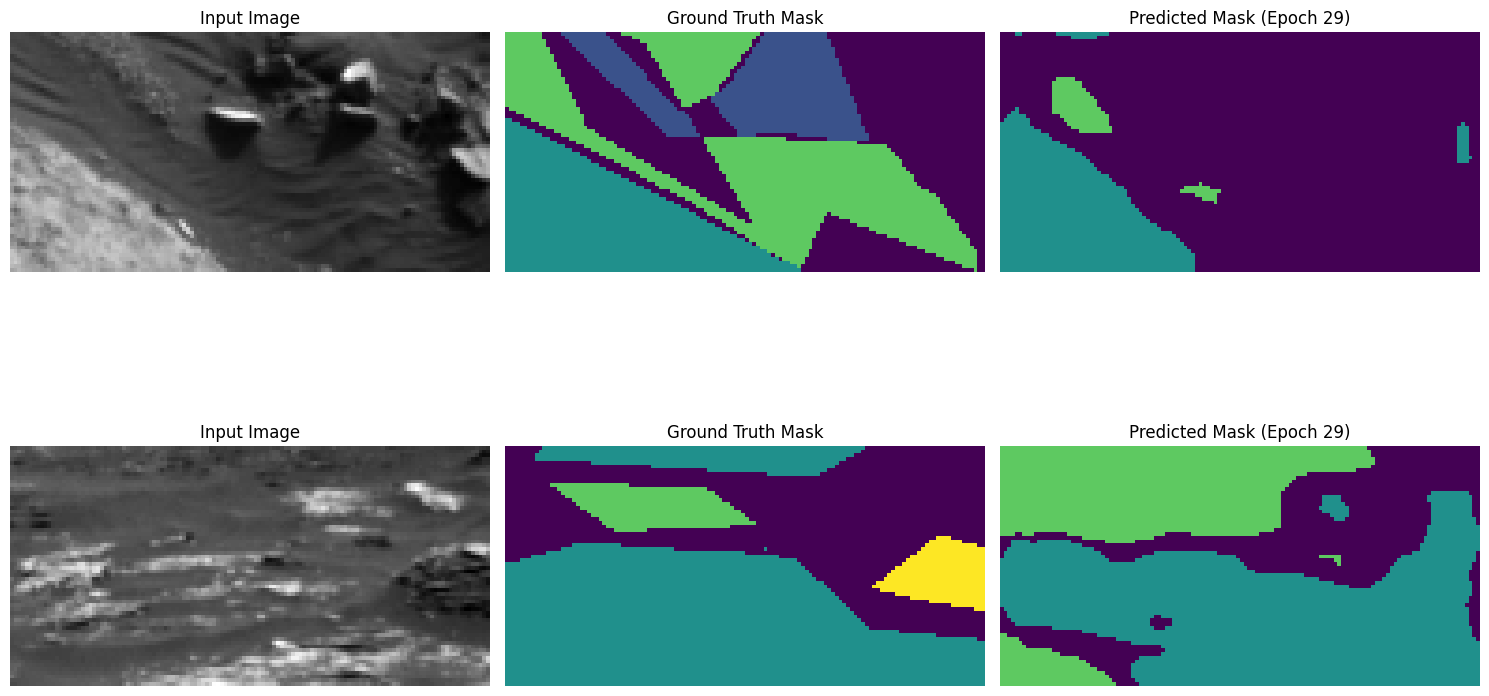

Epoch 30/50, Train Loss: 78.6085, Val Loss: 14.1924, Mean IoU: 0.4574, Val Accuracy: 0.7144
Class 0 IoU: 0.6835
Class 1 IoU: 0.5278
Class 2 IoU: 0.6178
Class 3 IoU: 0.0007


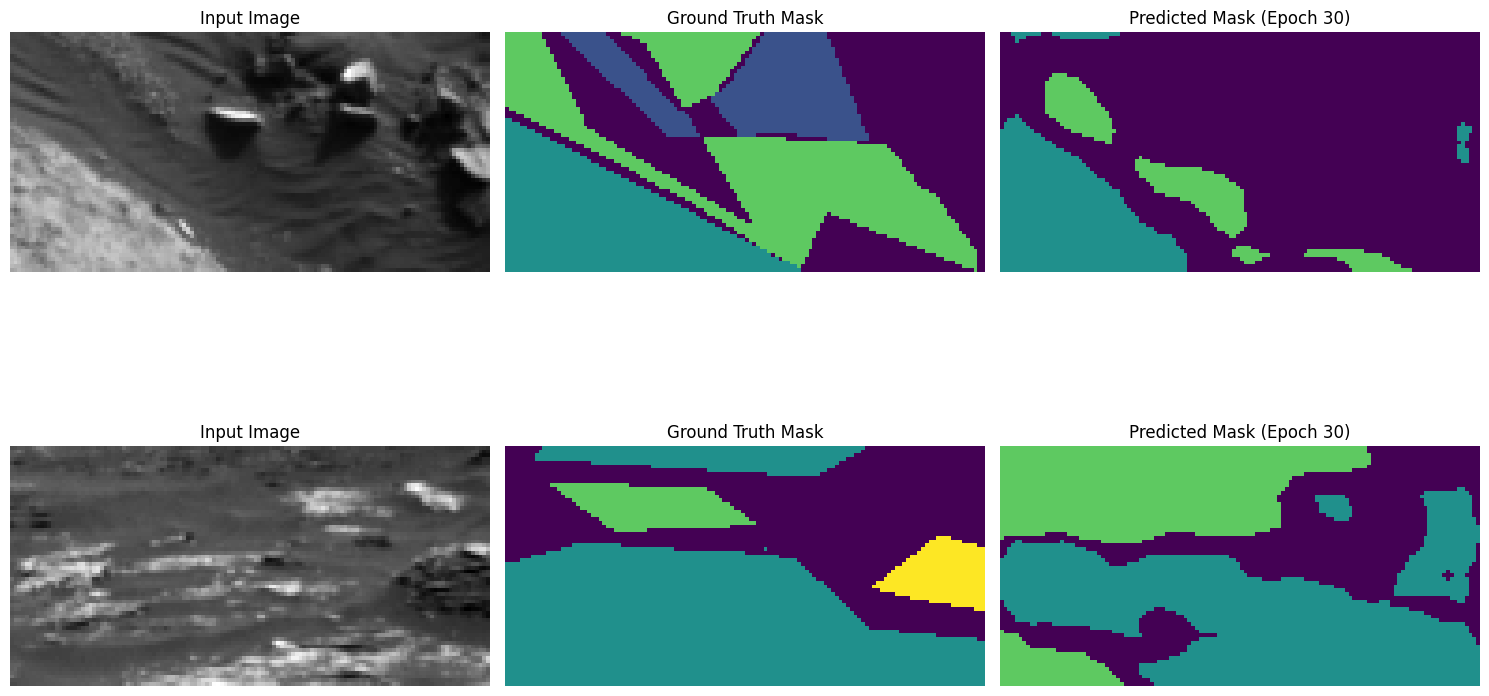

Epoch 31/50, Train Loss: 78.1763, Val Loss: 14.5820, Mean IoU: 0.4590, Val Accuracy: 0.7154
Class 0 IoU: 0.6774
Class 1 IoU: 0.5318
Class 2 IoU: 0.6267
Class 3 IoU: 0.0000


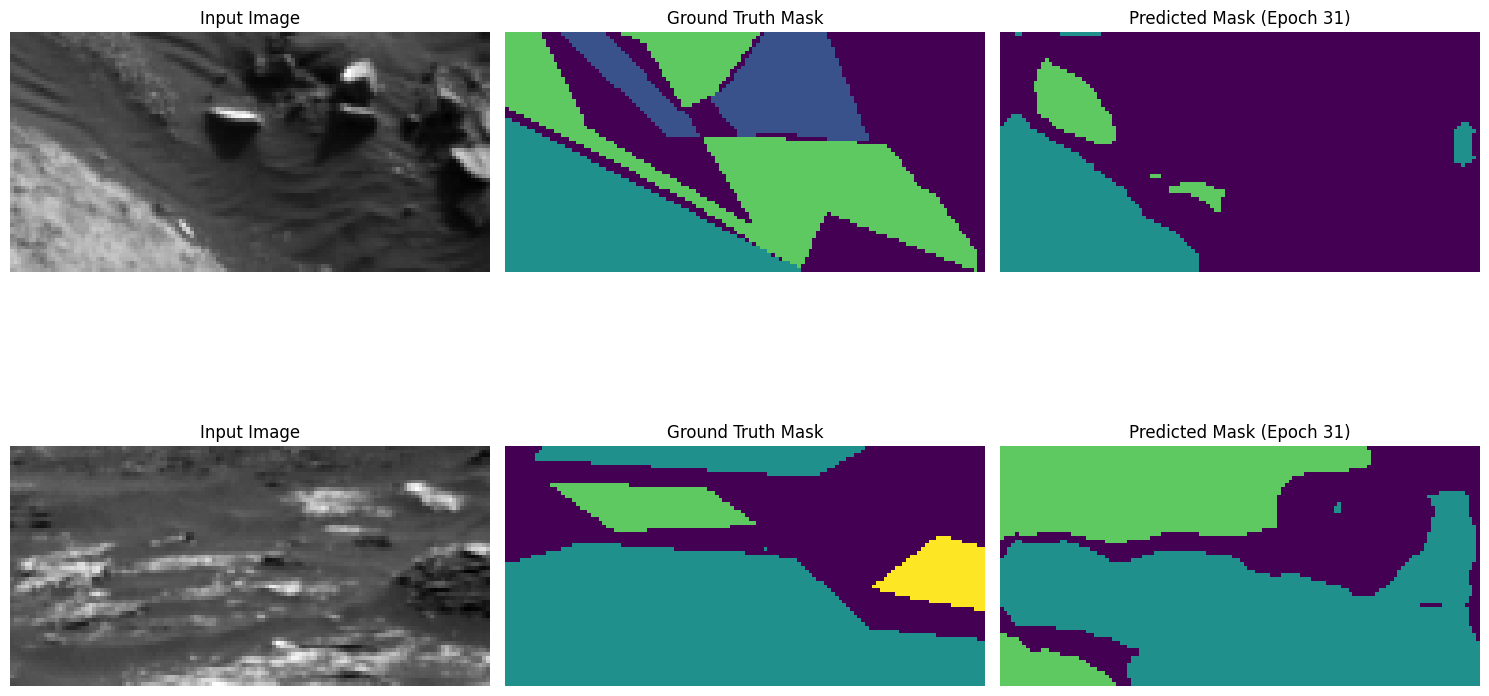

Epoch 32/50, Train Loss: 76.6959, Val Loss: 14.0996, Mean IoU: 0.4577, Val Accuracy: 0.7108
Class 0 IoU: 0.6779
Class 1 IoU: 0.5146
Class 2 IoU: 0.6153
Class 3 IoU: 0.0229


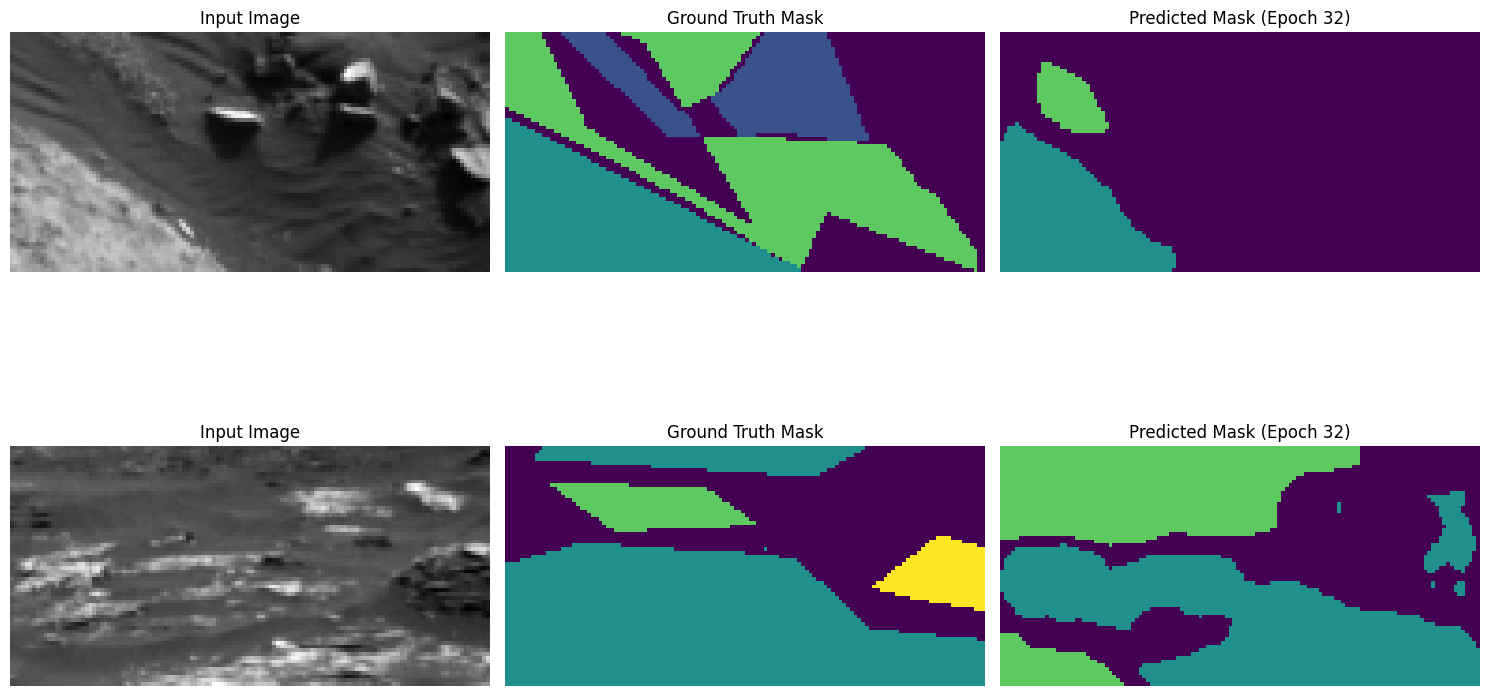

Epoch 33/50, Train Loss: 75.7236, Val Loss: 14.8861, Mean IoU: 0.4546, Val Accuracy: 0.7118
Class 0 IoU: 0.6779
Class 1 IoU: 0.5285
Class 2 IoU: 0.6121
Class 3 IoU: 0.0000


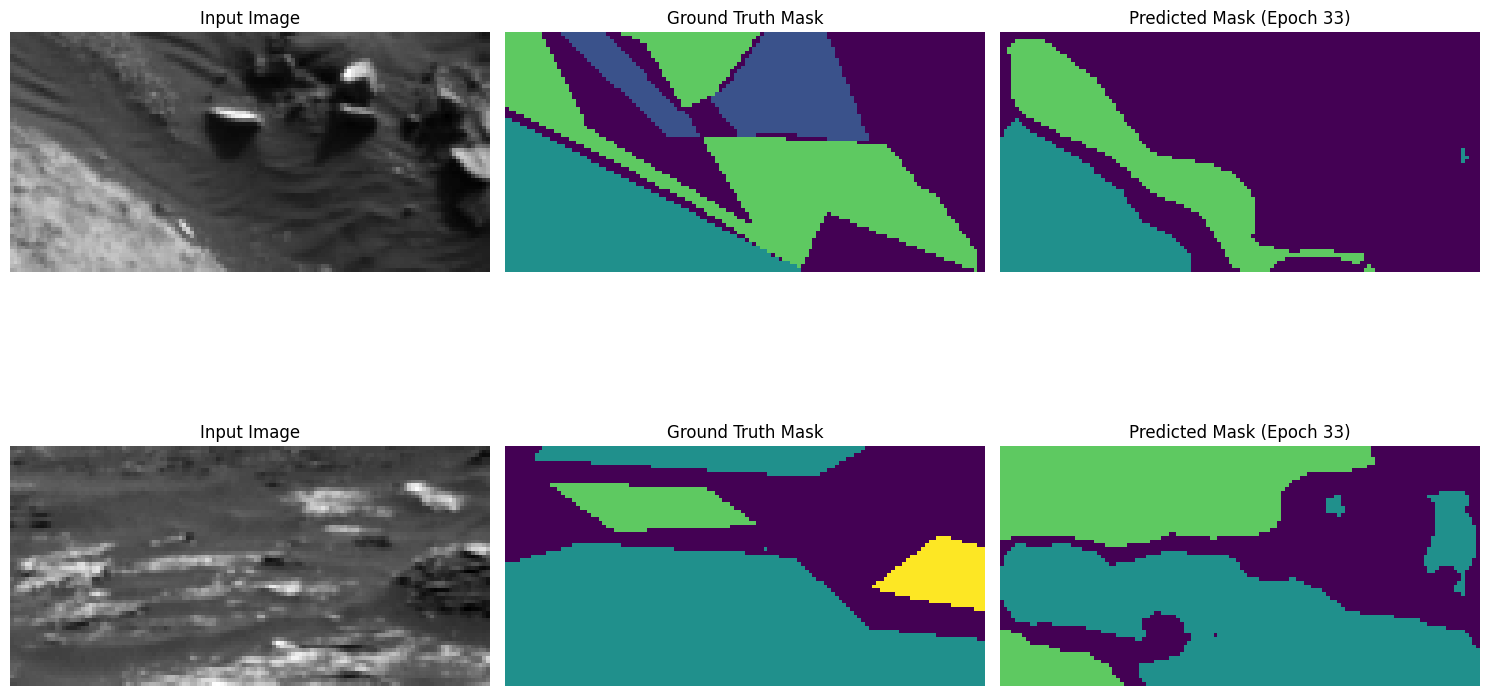

Epoch 34/50, Train Loss: 72.1147, Val Loss: 15.0364, Mean IoU: 0.4595, Val Accuracy: 0.7170
Class 0 IoU: 0.6845
Class 1 IoU: 0.5377
Class 2 IoU: 0.6157
Class 3 IoU: 0.0000


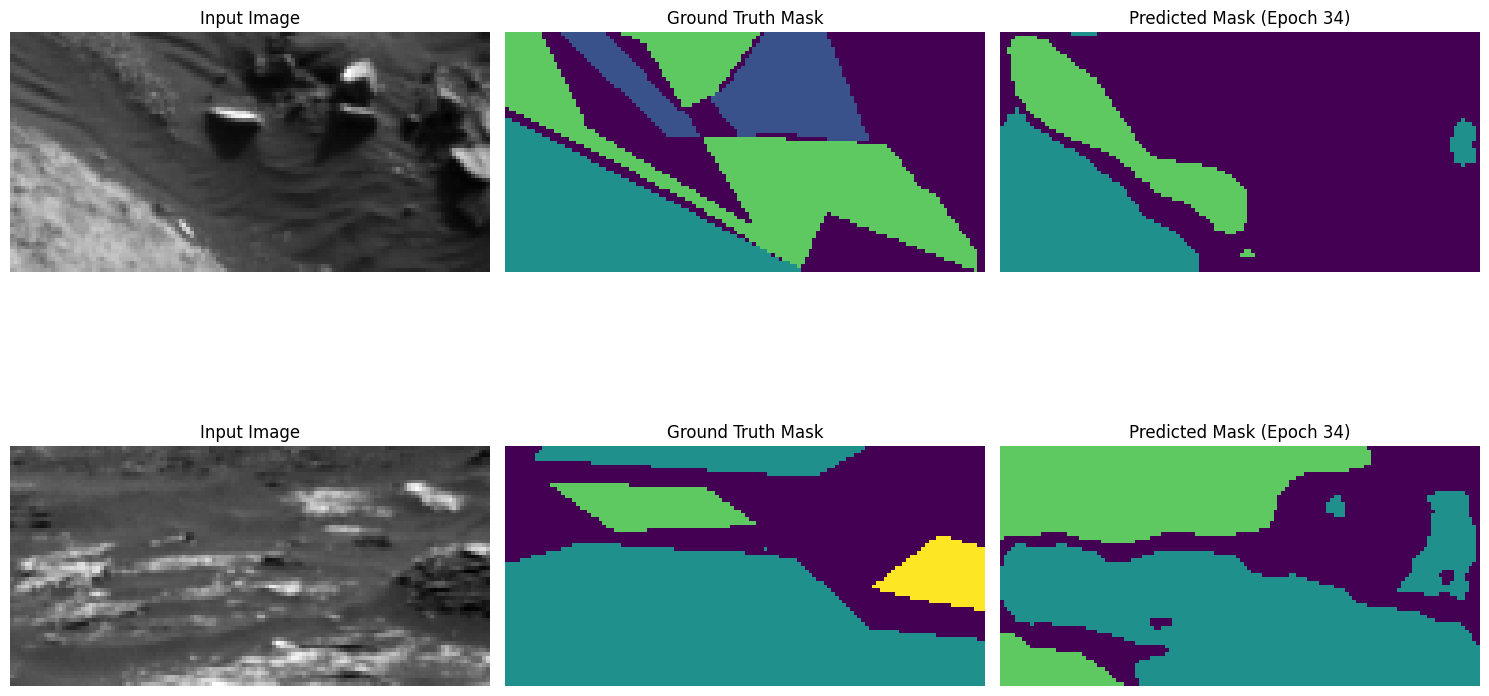

Epoch 35/50, Train Loss: 71.3677, Val Loss: 15.0342, Mean IoU: 0.4517, Val Accuracy: 0.7091
Class 0 IoU: 0.6726
Class 1 IoU: 0.5207
Class 2 IoU: 0.6135
Class 3 IoU: 0.0001


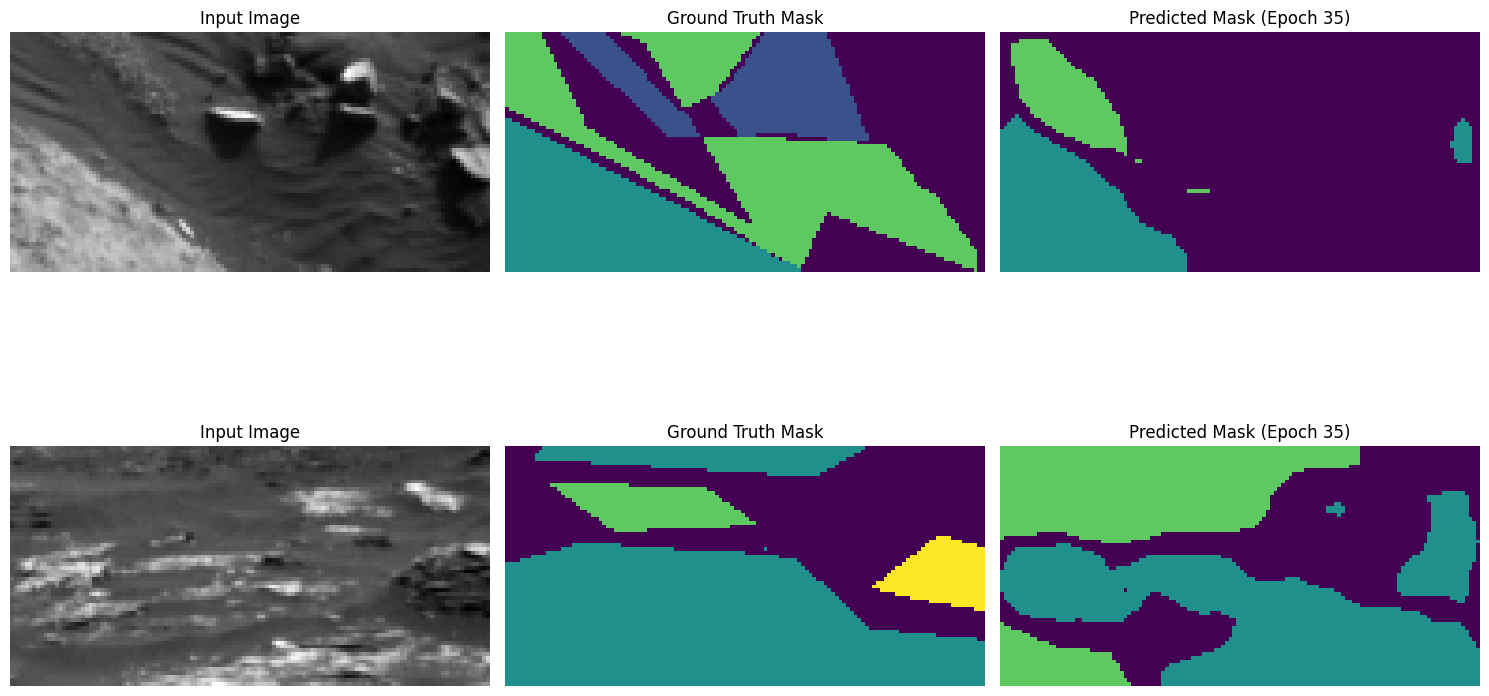

Epoch 36/50, Train Loss: 70.8280, Val Loss: 14.9124, Mean IoU: 0.4542, Val Accuracy: 0.7097
Class 0 IoU: 0.6730
Class 1 IoU: 0.5255
Class 2 IoU: 0.6181
Class 3 IoU: 0.0000


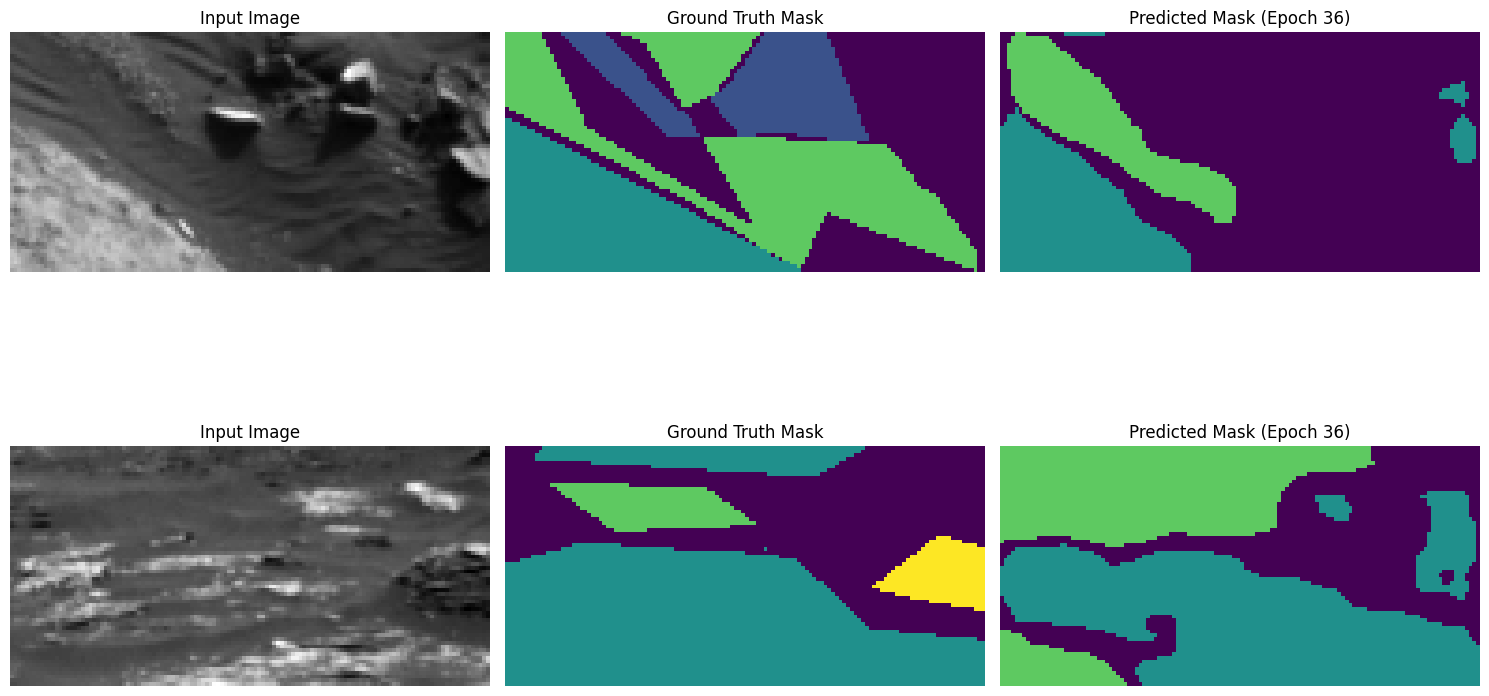

Epoch 37/50, Train Loss: 69.2064, Val Loss: 15.1852, Mean IoU: 0.4522, Val Accuracy: 0.7089
Class 0 IoU: 0.6741
Class 1 IoU: 0.5164
Class 2 IoU: 0.6184
Class 3 IoU: 0.0000


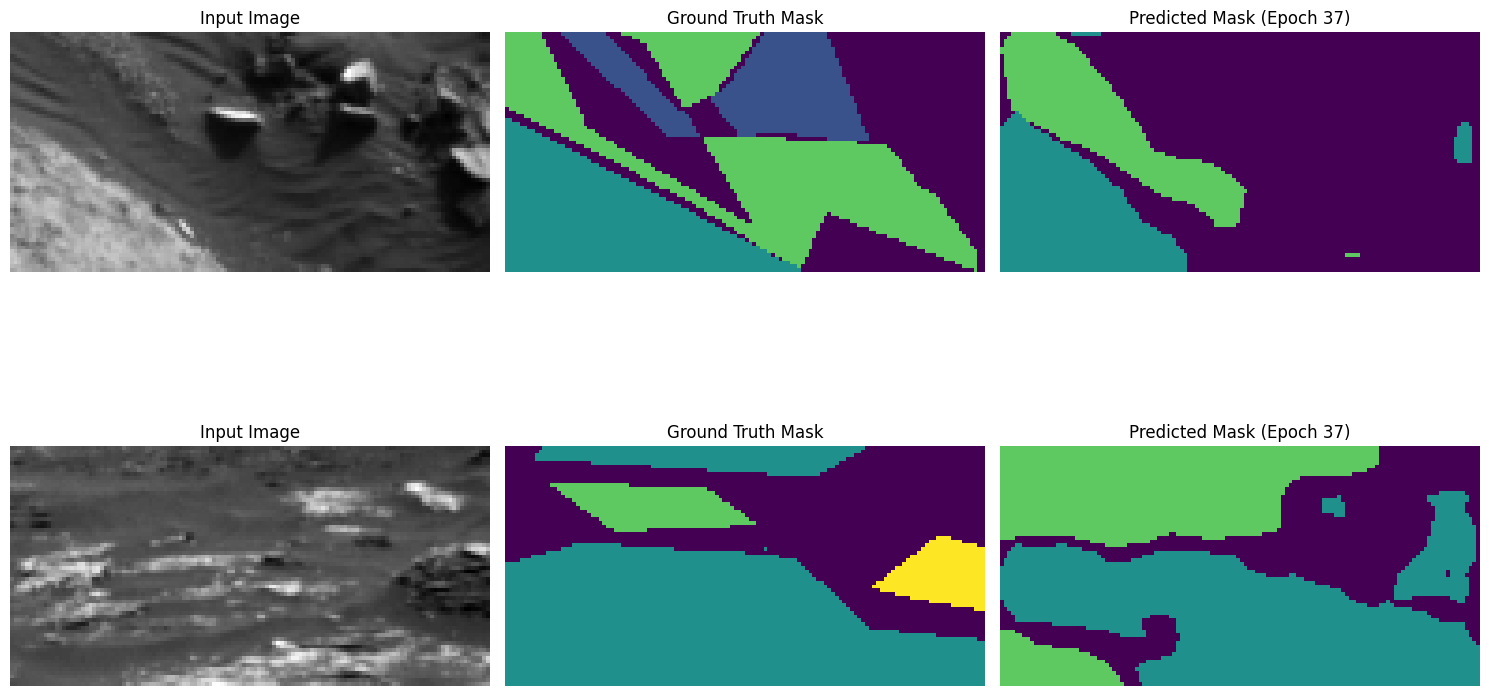

Epoch 38/50, Train Loss: 68.7309, Val Loss: 14.8358, Mean IoU: 0.4599, Val Accuracy: 0.7114
Class 0 IoU: 0.6738
Class 1 IoU: 0.5328
Class 2 IoU: 0.6175
Class 3 IoU: 0.0155


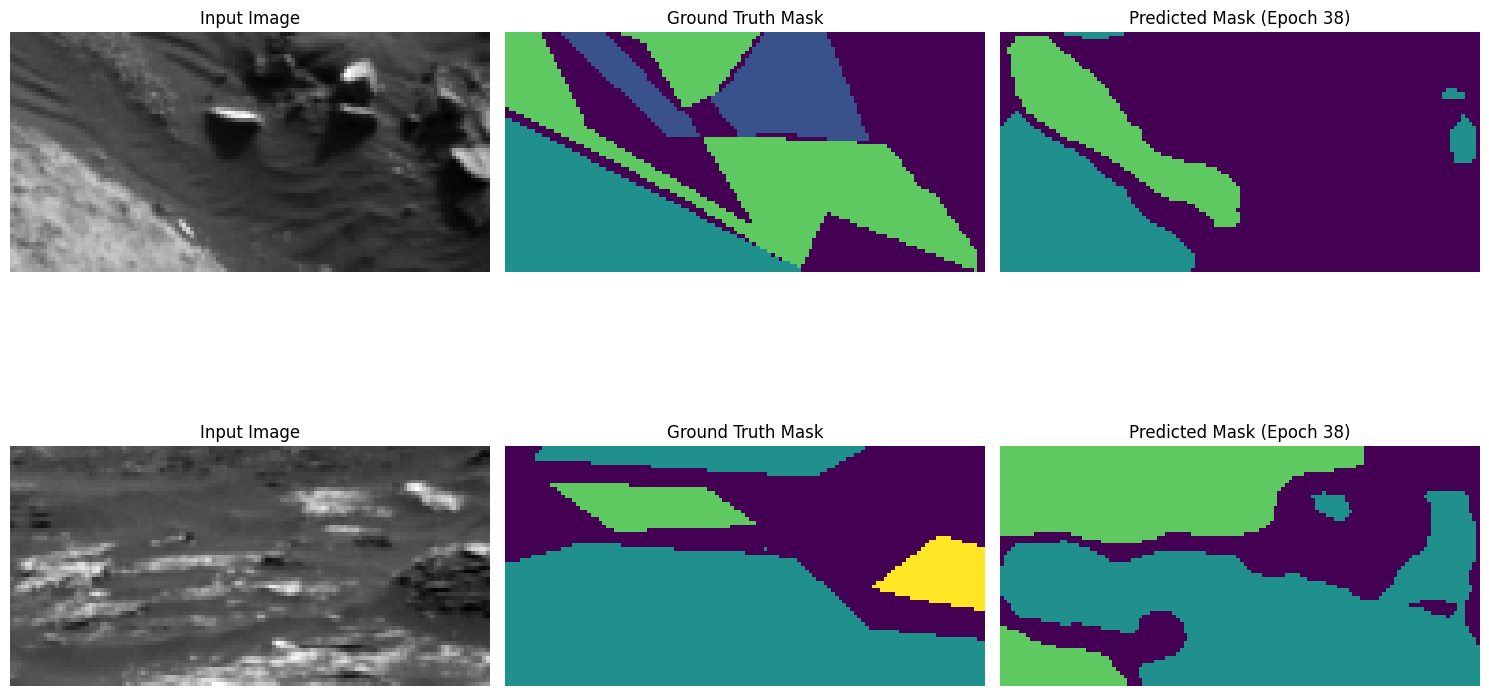

Epoch 39/50, Train Loss: 68.8475, Val Loss: 15.0586, Mean IoU: 0.4530, Val Accuracy: 0.7077
Class 0 IoU: 0.6721
Class 1 IoU: 0.5222
Class 2 IoU: 0.6085
Class 3 IoU: 0.0093


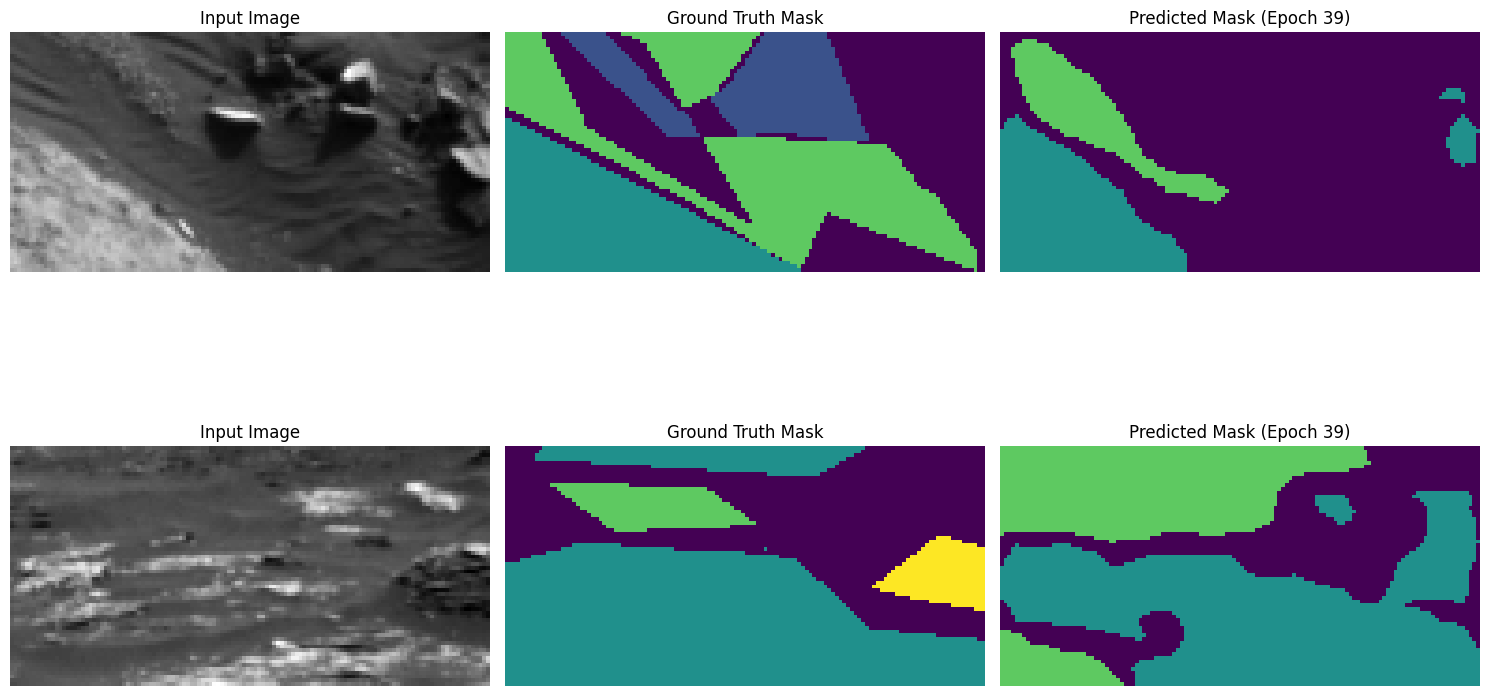

Early stopping triggered


In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define early stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Weighted Cross-Entropy Loss
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    def forward(self, logits, targets):
        loss = F.cross_entropy(logits, targets, weight=self.class_weights)
        return loss



criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

#criterion = WeightedCrossEntropyLoss(class_weights)
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Model initialization
def get_model():
    return smp.DeepLabV3Plus(
        encoder_name=hyperparams["model"]["encoder_name"],
        encoder_weights=hyperparams["model"]["encoder_weights"],
        in_channels=hyperparams["model"]["input_channels"],
        classes=hyperparams["model"]["num_classes"],
    ).to(device)

model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams["training"]["learning_rate"])

# Function to calculate mean IoU
def calculate_mean_iou(y_true, y_pred, num_classes, ignore_class=0):
    ious = []
    for c in range(num_classes):
        if c == ignore_class:
            continue
        y_true_c = (y_true == c).astype(int)
        y_pred_c = (y_pred == c).astype(int)
        intersection = (y_true_c & y_pred_c).sum()
        union = (y_true_c | y_pred_c).sum()
        iou = intersection / union if union > 0 else 0.0
        ious.append(iou)
    return np.mean(ious), ious

# Visualize predictions with at least 4 unique classes
def visualize_predictions(images, masks, predictions, epoch):
    # Filter images with at least 4 unique classes in the ground truth masks
    selected_indices = [i for i in range(len(masks)) if len(np.unique(masks[i])) >= 4]

    # Check if at least 2 such images exist
    if len(selected_indices) < 2:
        print("Not enough images with at least 4 unique classes for visualization.")
        return

    # Select the first 2 indices that satisfy the condition
    selected_indices = selected_indices[:2]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for idx, i in enumerate(selected_indices):  # Visualize 2 images
        axes[idx, 0].imshow(images[i].squeeze(), cmap="gray")
        axes[idx, 0].set_title("Input Image")
        axes[idx, 1].imshow(masks[i], cmap="viridis", vmin=0, vmax=4)
        axes[idx, 1].set_title("Ground Truth Mask")
        axes[idx, 2].imshow(predictions[i], cmap="viridis", vmin=0, vmax=4)
        axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
        axes[idx, 0].axis("off")
        axes[idx, 1].axis("off")
        axes[idx, 2].axis("off")
    plt.tight_layout()
    plt.show()

# Initialize best_val_mean_iou to a very low value
# Training loop
def train_model(model, train_loader, val_loader, hyperparams):
    best_val_loss = float("inf")
    best_val_mean_iou = 0.0
    best_val_accuracy = 0.0

    early_stopping = EarlyStopping(patience=hyperparams["training"].get("early_stopping_patience", 30))
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=hyperparams["training"].get("lr_plateau_patience", 5))

    for epoch in range(hyperparams["training"]["num_epochs"]):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0.0
        correct_pixels = 0
        total_pixels = 0
        all_predictions = []
        all_masks = []
        all_images = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_predictions.extend(preds)
                all_masks.extend(masks.cpu().numpy())
                all_images.extend(images.cpu().numpy())

                # Calculate accuracy
                correct_pixels += (preds == masks.cpu().numpy()).sum()
                total_pixels += np.prod(masks.shape)

        val_accuracy = correct_pixels / total_pixels
        mean_iou, per_class_ious = calculate_mean_iou(
            np.array(all_masks).flatten(),
            np.array(all_predictions).flatten(),
            num_classes=hyperparams["model"]["num_classes"],
            ignore_class=0,
        )

        print(f"Epoch {epoch+1}/{hyperparams['training']['num_epochs']}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Mean IoU: {mean_iou:.4f}, Val Accuracy: {val_accuracy:.4f}")

        for c, iou in enumerate(per_class_ious):
            print(f"Class {c} IoU: {iou:.4f}")

        visualize_predictions(
            np.array(all_images),
            np.array(all_masks),
            np.array(all_predictions),
            epoch,
        )

        if mean_iou > best_val_mean_iou:
            best_val_mean_iou = mean_iou
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Model saved with new best Mean IoU: {best_val_mean_iou:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model_acc.pth")
            print(f"Model saved with new best Validation Accuracy: {best_val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_loss.pth")
            print(f"Model saved with new best Validation Loss: {best_val_loss:.4f}")

        scheduler.step(val_loss)
        early_stopping(val_loss)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

# Train the model
train_model(model, train_loader, val_loader, hyperparams)


In [14]:
# Predict on test set
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            preds[preds == 0] = 4
            predictions.extend(preds)
    return np.array(predictions)

test_dataset = SegmentationDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions = predict(model, test_loader)

# Save predictions to CSV
def save_predictions_to_csv(predictions, filename="submission.csv"):
    n_samples = predictions.shape[0]
    preds_flat = predictions.reshape(n_samples, -1)
    submission = pd.DataFrame(preds_flat)
    submission["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in submission.columns if col != "id"]
    submission = submission[cols]
    submission.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

save_predictions_to_csv(predictions)

Predictions saved to submission.csv
